# Gold Standard and Cell2location Analysis

In [ ]:
import os
import scanpy as sc
import sys
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

sys.path.append('..')
import optuna
from TUT import tut
def find_best_trial(dataset):

    storage_url = "sqlite:///optuna_study_wassgard.db"  # Replace with your storage URL (e.g., SQLite database)

    study_name = f"wassgard_{dataset}"  # Replace with your study name

    study = optuna.load_study(study_name=study_name, storage=storage_url)

    best_trials = study.best_trials

    # Sort the trials by the first number (descending) and second number (ascending)
    sorted_trials = sorted(
        best_trials,
        key=lambda trial: (-trial.values[0], trial.values[1])
    )

    # Check if the best trial satisfies both conditions (highest first and lowest second)
    best_trial = sorted_trials[0]
    if best_trial.values[1] < 0.1:
        return best_trial

    # If not, find a trial where the first value is in the top 3 and the second is < 0.1
    for trial in sorted_trials[:3]:  # Top 3 trials by the first value
        if trial.values[1] < 0.1:
            return trial

    # If no such trial exists, return the first trial in the sorted list
    return best_trial

base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
data_dir = os.path.join(base_dir, "data")
results_dir = tut.process.utils.check_dir(os.path.join(base_dir, "ismb_results_wassgard"))
manuscript_dir = r'Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard'

# experiments_list = ["cot", "cnmf", "ot", "nmf", "lda"]
experiments_list = ["ot", "cnmf", "nmf", "stdecon"]

dataset_list = {
    "Dataset10_STARmap_li2022_sim_norm_mm" : {
        "fig_width": 5,
        "fig_height": 10,
        "ot" : {
            "h" : 0.01,
            "w" : 1e-2,
            "eps": 5e-3,
            "lr": 0.001,
            "optm": "adam",
            "cost": "cosine"
        }
    },
    "Dataset4_seqFISH_li2022_sim_norm_mm" : {
        "fig_width": 10,
        "fig_height": 5,
        "ot" : {
            "h" : 0.01,
            "w" : 1e-2,
            "eps": 5e-3,
            "lr": 0.001,
            "optm": "adam",
            "cost": "cosine"
        }
    },
    "MOB_dance_sim_norm_mm": {
        "fig_width": 10,
        "fig_height": 5,
        "ot" : {
            "h" : 0.01,
            "w" : 1e-2,
            "eps": 5e-3,
            "lr": 0.001,
            "optm": "adam",
            "cost": "cosine"
        },
    },
    # "GSE174746_dance_sim_norm_hg": { ## works when turn off selecting highly variable genes
    #     'generate_locations': True,
    #     "fig_width": 2,
    #     "fig_height": 2,
    #     "ot" : {
    #         "h" : 0.01,
    #         "w" : 0.001,
    #         "eps": 0.005,
    #         "lr": 0.001,
    #         "optm": "adam",
    #         "cost": "cosine"
    #     }
    # },
    "Synthetic_Spotlight": {
        'generate_locations': True,
        "fig_width": 7,
        "fig_height": 10,
        "ot" : {
            "h" : 0.005,
            "w" : 0.001,
            "eps": 0.05,
            "lr": 0.0005,
            "optm": "adam",
            "cost": "cosine"
        }
    },
    # "MouseBrain_dance_sim_norm_mm":{
    #     "fig_width": 10,
    #     "fig_height": 5,
    #     "ot" : {
    #         "h" : 0.01,
    #         "w" : 1e-2,
    #         "eps": 5e-3,
    #         "lr": 0.001,
    #         "optm": "adam",
    #         "cost": "cosine"
    #     },
    # },
    "stereoseq_mouse_brain_li2023_sim_norm_mm": {
        "fig_width": 60,
        "fig_height": 65,
        "ot" : {
            "h" : 0.01,
            "w" : 1e-2,
            "eps": 5e-3,
            "lr": 0.001,
            "optm": "adam",
            "cost": "cosine"
        }
    },
}
# data_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\data\dance"
# dataset_list = {
#     x: {
#         "ot": {
#             "h": 0.05,
#             "w": 0.01,
#             "eps": 0.05,
#             "lr": 0.001,
#             "optm": "adam",
#             "cost": "cosine"
#         }
#     }
#     for x in os.listdir(data_dir)
# }
running_experiments = ["ot"]
running_datasets = ["stereoseq_mouse_brain_li2023_sim_norm_mm"]


In [ ]:
for dataset in running_datasets:
    print(f"Starting {dataset}")

    if(dataset == "stereoseq_mouse_brain_li2023_sim_norm_mm"):
        steroseq_dataset_path = os.path.join(data_dir, dataset)              
        adata_spatial = tut.process.io.get_xeno_spatial_data(steroseq_dataset_path, sample_name=dataset)
    else:
        dataset_path = os.path.join(data_dir, dataset)
        adata_spatial = sc.read_h5ad(os.path.join(dataset_path, "adata_spatial.h5ad"))


    for key in adata_spatial.uns["paths"]:
        adata_spatial.uns["paths"][key] = adata_spatial.uns["paths"][key].replace("D:", "Z:")

    adata_spatial.uns["dataset_name"] = dataset
    sample_name = dataset
    print(sample_name, adata_spatial.X.shape)

    adata_spatial.uns["params"]=dataset_list[dataset]
    best_trial = find_best_trial(dataset)
    adata_spatial.uns["params"]["ot"] = best_trial.params

    """Run experiments and annotations for a given adata."""
    for exp_name in running_experiments:

        exp_path = os.path.join(results_dir, sample_name, f"{exp_name}_{sample_name}")
        if os.path.exists(exp_path) and any(f.startswith('topics_per_spot') for f in os.listdir(exp_path)):
            print("File found. Continuing...")
            continue

        print(sample_name, exp_name)
        k = len(adata_spatial.uns["ground_truth"].columns) 

        if(exp_name == "ot"):
            print(adata_spatial.uns["params"]["ot"])

        tut.run_experiment(adata_spatial.copy(), k, sample_name, exp_name,
                            results_dir = os.path.join(results_dir, sample_name), filter_genes=True)

        tut.annotate.annotate_with_benchmark(os.path.join(results_dir, sample_name), adata_spatial, exp_name=exp_name, correlation_type = 'cosine', top_n_features = 500)

    tut.annotate.annot_corr_heatmap(results_dir, adata_spatial, experiments_list, correlation_type = 'cosine', is_triangle=False, is_show=True)
        # # Golden Standard Benchmark
    tut.benchmark.run_benchmark_with_ground_truth(results_dir, adata_spatial, experiments_list, is_show=True)

    # plt.close('all')

    fig_width, fig_height = None, None
    if(dataset == "Dataset10_STARmap_li2022_sim_norm_mm"):
        fig_width, fig_height= 6, 30
    elif(dataset == "Dataset4_seqFISH_li2022_sim_norm_mm"):
        fig_width, fig_height= 10, 12
    elif(dataset == "Synthetic_Spotlight"):
         fig_width, fig_height= 15, 35
    elif(dataset == "MOB_dance_sim_norm_mm"):
        fig_width, fig_height= 12, 12
    elif(dataset == "stereoseq_mouse_brain_li2023_sim_norm_mm"):
        fig_width, fig_height= 10, 75
    tut.process.pl.plot_benchmark_methods_topics(results_dir, adata_spatial, experiments_list, fig_width=fig_width, fig_height=fig_height, use_scanpy=False, is_show=False)



Starting stereoseq_mouse_brain_li2023_sim_norm_mm
stereoseq_mouse_brain_li2023_sim_norm_mm (3000, 25879)
Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\ismb_results_wassgard\stereoseq_mouse_brain_li2023_sim_norm_mm\analysis
10 75


## Sparsity

In [89]:
import os 
import pandas as pd 
import scanpy as sc 
import sys
import numpy as np
sys.path.append('..')
from Wassgard import models, hvg, eval


for dataset in running_datasets:
    print(f"Starting {dataset}")

    if(dataset == "stereoseq_mouse_brain_li2023_sim_norm_mm"):
        steroseq_dataset_path = os.path.join(data_dir, dataset)              
        adata_spatial = tut.process.io.get_xeno_spatial_data(steroseq_dataset_path, sample_name=dataset)
    else:
        dataset_path = os.path.join(data_dir, dataset)
        adata_spatial = sc.read_h5ad(os.path.join(dataset_path, "adata_spatial.h5ad"))


    for key in adata_spatial.uns["paths"]:
        adata_spatial.uns["paths"][key] = adata_spatial.uns["paths"][key].replace("D:", "Z:")
    sample_name = adata_spatial.uns["dataset_name"]
    print(sample_name, adata_spatial.X.shape)



    adata_spatial, overdispersed_genes = hvg.compute_overdispersed_genes(adata_spatial, save_dir=None, is_show=False)

    k = len(adata_spatial.uns["ground_truth"].columns) 
    ground_truth= adata_spatial.uns["ground_truth"]
    ground_truth.index = ground_truth.index.map(str)

    # How many cells that has zero (inverse) (another plot) and sum of cells (another plot)
    non_zero_count = (ground_truth != 0).sum()
    column_sum = ground_truth.sum().astype(int)
    non_zero_count_percentage = (non_zero_count / non_zero_count.sum()) * 100
    column_sum_percentage = (column_sum / column_sum.sum()) * 100


    # non_zero_indices = {col: ground_truth.index[ground_truth[col] != 0].tolist() for col in ground_truth.columns}
    # row_non_zero_counts_per_celltype = {}
    # for celltype in non_zero_indices.keys():
    #     # Select rows corresponding to the indices for the current cell type
    #     selected_rows = adata_spatial[non_zero_indices[celltype]].X
    #     row_non_zero_counts_per_celltype[celltype] = (selected_rows != 0).sum(axis=1).mean() ### may be all distribution


    # df_sparsity = pd.DataFrame.from_dict(row_non_zero_counts_per_celltype,  orient='index', columns=['mean_n_hvg_genes'])
    df_sparsity = pd.DataFrame(non_zero_count_percentage, columns=['pct_n_spots'])
    # df_sparsity.loc[non_zero_count.index, 'n_spots'] = non_zero_count.values
    df_sparsity.loc[column_sum_percentage.index, 'pct_n_cells'] = column_sum_percentage.values
    df_sparsity.to_csv(os.path.join(results_dir, sample_name, "analysis", f"sparsity_{sample_name}.csv"))


Starting Dataset10_STARmap_li2022_sim_norm_mm
Dataset10_STARmap_li2022_sim_norm_mm (189, 882)
Selecting Genes with alpha 0.05 and use_unadjusted_pvals True is_spatial False
Initial data: 189 spots, 882 genes
Spots after filtering: 189
Genes after filtering: 882
Using GAM model with k=5 ...
Identified 108 overdispersed genes.
Starting Dataset4_seqFISH_li2022_sim_norm_mm
Dataset4_seqFISH_li2022_sim_norm_mm (72, 9684)
Selecting Genes with alpha 0.05 and use_unadjusted_pvals True is_spatial False
Initial data: 72 spots, 9684 genes
Spots after filtering: 72
Genes after filtering: 9684
Using GAM model with k=5 ...
Identified 197 overdispersed genes.
Starting MOB_dance_sim_norm_mm
MOB_dance_sim_norm_mm (260, 18263)
Selecting Genes with alpha 0.05 and use_unadjusted_pvals True is_spatial False
Initial data: 260 spots, 18263 genes
Spots after filtering: 260
Genes after filtering: 13235
Using GAM model with k=5 ...
Identified 2503 overdispersed genes.
Starting MPBrain_dance_sim_norm_mm
MPBrain_d

## Summarization

In [ ]:
import pandas as pd
import numpy as np
import os

from scipy.stats import gmean

with pd.ExcelWriter(os.path.join(manuscript_dir, "Tables", "annotations.xlsx"), engine='xlsxwriter') as writer:
    for sample_name in running_datasets:
        print(f"Processing {sample_name}")
        annotations = []
        for exp_name in experiments_list:
            results_dir_path = os.path.join(results_dir, sample_name, f"{exp_name}_{sample_name}")
            df_annotation = tut.process.io.load_experiment_result(
                results_dir_path, sample_name=sample_name, exp_name=exp_name, mode="annotation"
            )
            df_annotation = df_annotation.set_index("celltype")
            df_annotation = df_annotation.sort_index()
            df_annotation = df_annotation.rename(columns={'program': exp_name})
            annotations.append(df_annotation)
        
        # Concatenate all annotations for the current sample
        annotations = pd.concat(annotations, axis=1)
        
        # Write the DataFrame to a sheet in the Excel file
        annotations.to_excel(writer, sheet_name=f'{sample_name.replace("_sim_norm_mm","")}')

Processing Dataset10_STARmap_li2022_sim_norm_mm
Processing Dataset4_seqFISH_li2022_sim_norm_mm
Processing MOB_dance_sim_norm_mm
Processing MPBrain_dance_sim_norm_mm
Processing stereoseq_mouse_brain_li2023_sim_norm_mm


In [ ]:
import pandas as pd
import numpy as np
import os


metric_list = ["PCC", "COSINE", "RMSE", "JS", "AS_S"]         # Replace with your metrics

results = {}

# Iterate over each dataset and compute metrics
for sample_name in dataset_list:
    # Construct path and load CSV
    metric_name_path = os.path.join(results_dir, sample_name, "analysis", f"metrics_{sample_name}.csv")
    dfs = pd.read_csv(metric_name_path)
    
    # Create a dictionary to hold metrics for each method
    dataset_results = {}
    for method in experiments_list:
        method_data = dfs[dfs['experiment'] == method]
        #dataset_results[method] = {metric: gmean(np.abs(method_data[metric].values)) for metric in metric_list}
        dataset_results[method] = {metric: method_data[metric].values.mean() for metric in metric_list}
    # Add results for the current dataset
    results[sample_name] = pd.DataFrame(dataset_results).T

# Combine results into a single DataFrame with MultiIndex columns
multi_index_columns = pd.MultiIndex.from_product([dataset_list, metric_list], names=["Dataset", "Metric"])
df = pd.DataFrame(index=experiments_list, columns=multi_index_columns)

# Populate the DataFrame
for dataset, dataset_df in results.items():
    for metric in metric_list:
        df[(dataset, metric)] = dataset_df[metric]

# df = df.loc[df.index!="cnmf",:]
# df = df.loc[df.index!="lda",:]
df = df.T

def highlight_extreme_row(s):
    # Determine whether to maximize or minimize based on the metric name
    if s.name[1] in ["PCC", "SSIM", "COSINE", "AS_S", "MGS", "RBO", "nDCG", "AS_G"]:  # Metrics where higher is better
        is_extreme = s == s.max()
    elif s.name[1] in ["RMSE", "JS"]:  # Metrics where lower is better
        is_extreme = s == s.min()
    else:
        is_extreme = [False] * len(s)  # Default: no formatting

    # Return styling for the row
    return ['font-weight: bold' if v else '' for v in is_extreme]


# Apply the highlight function to each column
styled_df = df.style.format("{:.3f}")  # Format the numeric values
styled_df = styled_df.apply(highlight_extreme_row, axis=1)  # Apply row-wise styling
# styled_df.to_csv()
# styled_df.to_excel(os.path.join(manuscript_dir,'Tables\Overall_spot_metrics_table.xlsx'), engine='openpyxl', index=True)  # Save with index
styled_df

In [ ]:
import pandas as pd
import numpy as np
import os


metric_list = [ "RBO", "nDCG", "AS_G"]         # Replace with your metrics

results = {}

# Iterate over each dataset and compute metrics
for sample_name in dataset_list:
    # Construct path and load CSV
    metric_name_path = os.path.join(results_dir, sample_name, "analysis", f"metrics_{sample_name}.csv")
    dfs = pd.read_csv(metric_name_path)
    
    # Create a dictionary to hold metrics for each method
    dataset_results = {}
    for method in experiments_list:
        method_data = dfs[dfs['experiment'] == method]
        #dataset_results[method] = {metric: gmean(np.abs(method_data[metric].values)) for metric in metric_list}
        dataset_results[method] = {metric: method_data[metric].values.mean() for metric in metric_list}
    # Add results for the current dataset
    results[sample_name] = pd.DataFrame(dataset_results).T

# Combine results into a single DataFrame with MultiIndex columns
multi_index_columns = pd.MultiIndex.from_product([dataset_list, metric_list], names=["Dataset", "Metric"])
df = pd.DataFrame(index=experiments_list, columns=multi_index_columns)

# Populate the DataFrame
for dataset, dataset_df in results.items():
    for metric in metric_list:
        df[(dataset, metric)] = dataset_df[metric]

# df = df.loc[df.index!="cnmf",:]
# df = df.loc[df.index!="lda",:]
df = df.T

def highlight_extreme_row(s):
    # Determine whether to maximize or minimize based on the metric name
    if s.name[1] in ["PCC", "SSIM", "COSINE", "AS_S", "MGS", "RBO", "nDCG", "AS_G"]:  # Metrics where higher is better
        is_extreme = s == s.max()
    elif s.name[1] in ["RMSE", "JS"]:  # Metrics where lower is better
        is_extreme = s == s.min()
    else:
        is_extreme = [False] * len(s)  # Default: no formatting

    # Return styling for the row
    return ['font-weight: bold' if v else '' for v in is_extreme]


# Apply the highlight function to each column
styled_df = df.style.format("{:.3f}")  # Format the numeric values
styled_df = styled_df.apply(highlight_extreme_row, axis=1)  # Apply row-wise styling
# styled_df.to_csv()
styled_df.to_excel(os.path.join(manuscript_dir,'Tables\Overall_gene_metrics_table.xlsx'), engine='openpyxl', index=True)  # Save with index
styled_df

In [ ]:
def create_highlight_mask(df):
    # Initialize a mask with False values
    mask = pd.DataFrame(False, index=df.index, columns=df.columns)
    
    for idx, row in df.iterrows():
        for col in df.columns:
            metric_name = idx[1]  # Assuming multi-index columns and metric at level 1
            if metric_name in ["PCC", "SSIM", "COSINE", "AS_S", "RBO", "nDCG", "AS_G"]:  # Higher is better
                mask.loc[idx, col] = row[col] == row.max()
            elif metric_name in ["RMSE", "JS"]:  # Lower is better
                mask.loc[idx, col] = row[col] == row.min()
    
    return mask


# LaTeX generation function
def styled_to_latex_with_bold_and_format(df, highlight_mask):
    formatted_latex = ""

    # Start the table environment
    formatted_latex += "\\begin{tabular}{l" + "r" * len(df.columns) + "}\n"
    formatted_latex += "\\toprule\n"

    # Add multi-index columns if present
    if isinstance(df.columns, pd.MultiIndex):
        col_levels = df.columns.levels
        col_codes = df.columns.codes
        
        for level_idx, level in enumerate(col_levels):
            row = [""] + [
                f"\\multicolumn{{1}}{{c}}{{{level[code]}}}"
                for code in col_codes[level_idx]
            ]
            formatted_latex += " & ".join(row) + " \\\\\n"
    else:
        # Single-level column headers
        formatted_latex += " & ".join([""] + [str(col) for col in df.columns]) + " \\\\\n"

    # Add rows
    # row = ['\multirow{5}{*}{'+row_index[0].replace("_sim_norm_mm","").replace("_","\_")+'}\n']

    for row_index, row_data in df.iterrows():
        row = [f'& {row_index[1].replace("_S","")}']  # First column is the index
        for col_index, value in row_data.items():
            formatted_value = f"{value:.3f}"  # Format value with three decimals

            # Check the highlight_mask for bold formatting
            if highlight_mask.loc[row_index, col_index]:
                formatted_value = f"\\textbf{{{formatted_value}}}"
            row.append(formatted_value)
        formatted_latex += " & ".join(row) + " \\\\\n"

    # End the table
    formatted_latex += "\\bottomrule\n\\end{tabular}\n"
    return formatted_latex

# Example usage
# Assuming df is your DataFrame
highlight_mask = create_highlight_mask(df)
latex_output = styled_to_latex_with_bold_and_format(df, highlight_mask)

print(latex_output)

## Cell Type Statistics 

In [96]:
import pandas as pd
import os 
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
data_dir = os.path.join(base_dir, "data")
results_dir = os.path.join(base_dir, "ismb_results_wassgard")
metric="nDCG"



def get_contingency_table(sample_name, baseline_th = 0.3, improvment_th=0):

    df_metrics = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", f"metrics_{sample_name}.csv"))
    df_pivot = df_metrics.pivot(index="celltype", columns="experiment", values=metric)
    correlation_type = "cosine"
    df_corr = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", "correlations", f"{sample_name}_{correlation_type}.csv"), index_col=0)
    np.fill_diagonal(df_corr.values, 0)


    improvement = df_pivot['ot'] - df_pivot['cnmf']


    # Condition masks
    improved = improvement >= improvment_th
    not_improved = improvement < improvment_th
    baseline_high = df_corr.max() >= baseline_th
    baseline_low = df_corr.max() < baseline_th

    # Contingency table counts
    a = ((improved) & (baseline_high)).sum()   # OT improves ≥0.1 & baseline ≥0.3
    b = ((improved) & (baseline_low)).sum()    # OT improves ≥0.1 & baseline <0.3
    c = ((not_improved) & (baseline_low)).sum() # OT doesn't improve ≥0.1 & baseline <0.3
    d = ((not_improved) & (baseline_high)).sum() # OT doesn't improve ≥0.1 & baseline ≥0.3

    # Contingency table
    contingency_table = [[a, b],
                        [d, c]]  # Note: Fisher's test expects a 2x2 table
    
    return np.array(contingency_table)
    

cont1 = get_contingency_table(sample_name = "Dataset10_STARmap_li2022_sim_norm_mm")
cont2 = get_contingency_table(sample_name = "stereoseq_mouse_brain_li2023_sim_norm_mm")
cont3 = get_contingency_table(sample_name = "Dataset4_seqFISH_li2022_sim_norm_mm")
cont4 = get_contingency_table(sample_name = "MOB_dance_sim_norm_mm", baseline_th=0.6)
cont5 = get_contingency_table(sample_name = "Synthetic_Spotlight")

cont = cont1 + cont2 + cont3   


print(f"1️⃣ Programs where OT improves  over cNMF AND baseline >= threshold: {cont[0][0]}")
print(f"2️⃣ Programs where OT improves  over cNMF AND baseline < threshold: {cont[0][1]}")
print(f"3️⃣ Programs where OT does NOT improve over cNMF AND baseline < threshold: {cont[1][0]}")
print(f"4️⃣ Programs where OT does NOT improve  over cNMF AND baseline >= threshold: {cont[1][1]}")


from scipy.stats import barnard_exact
ber = barnard_exact(cont, alternative='two-sided')
print(ber)

from scipy.stats import fisher_exact
odds_ratio, p_value = fisher_exact(cont, alternative='two-sided')
print(f"FisherExactResult: OddsRatio: {odds_ratio}, pvalue: {p_value}")


# stat, p_value = wilcoxon(df_pivot["ot"], df_pivot["cnmf"])
# print(stat,p_value)
# print(f"cosine metric:{metric} Wilcoxon SRT: statistic={stat:.3f} p-value={p_value:.3f}")


1️⃣ Programs where OT improves  over cNMF AND baseline >= threshold: 16
2️⃣ Programs where OT improves  over cNMF AND baseline < threshold: 15
3️⃣ Programs where OT does NOT improve over cNMF AND baseline < threshold: 14
4️⃣ Programs where OT does NOT improve  over cNMF AND baseline >= threshold: 12
BarnardExactResult(statistic=-0.16818989622170258, pvalue=0.8874526576201465)
FisherExactResult: OddsRatio: 0.9142857142857143, pvalue: 1.0


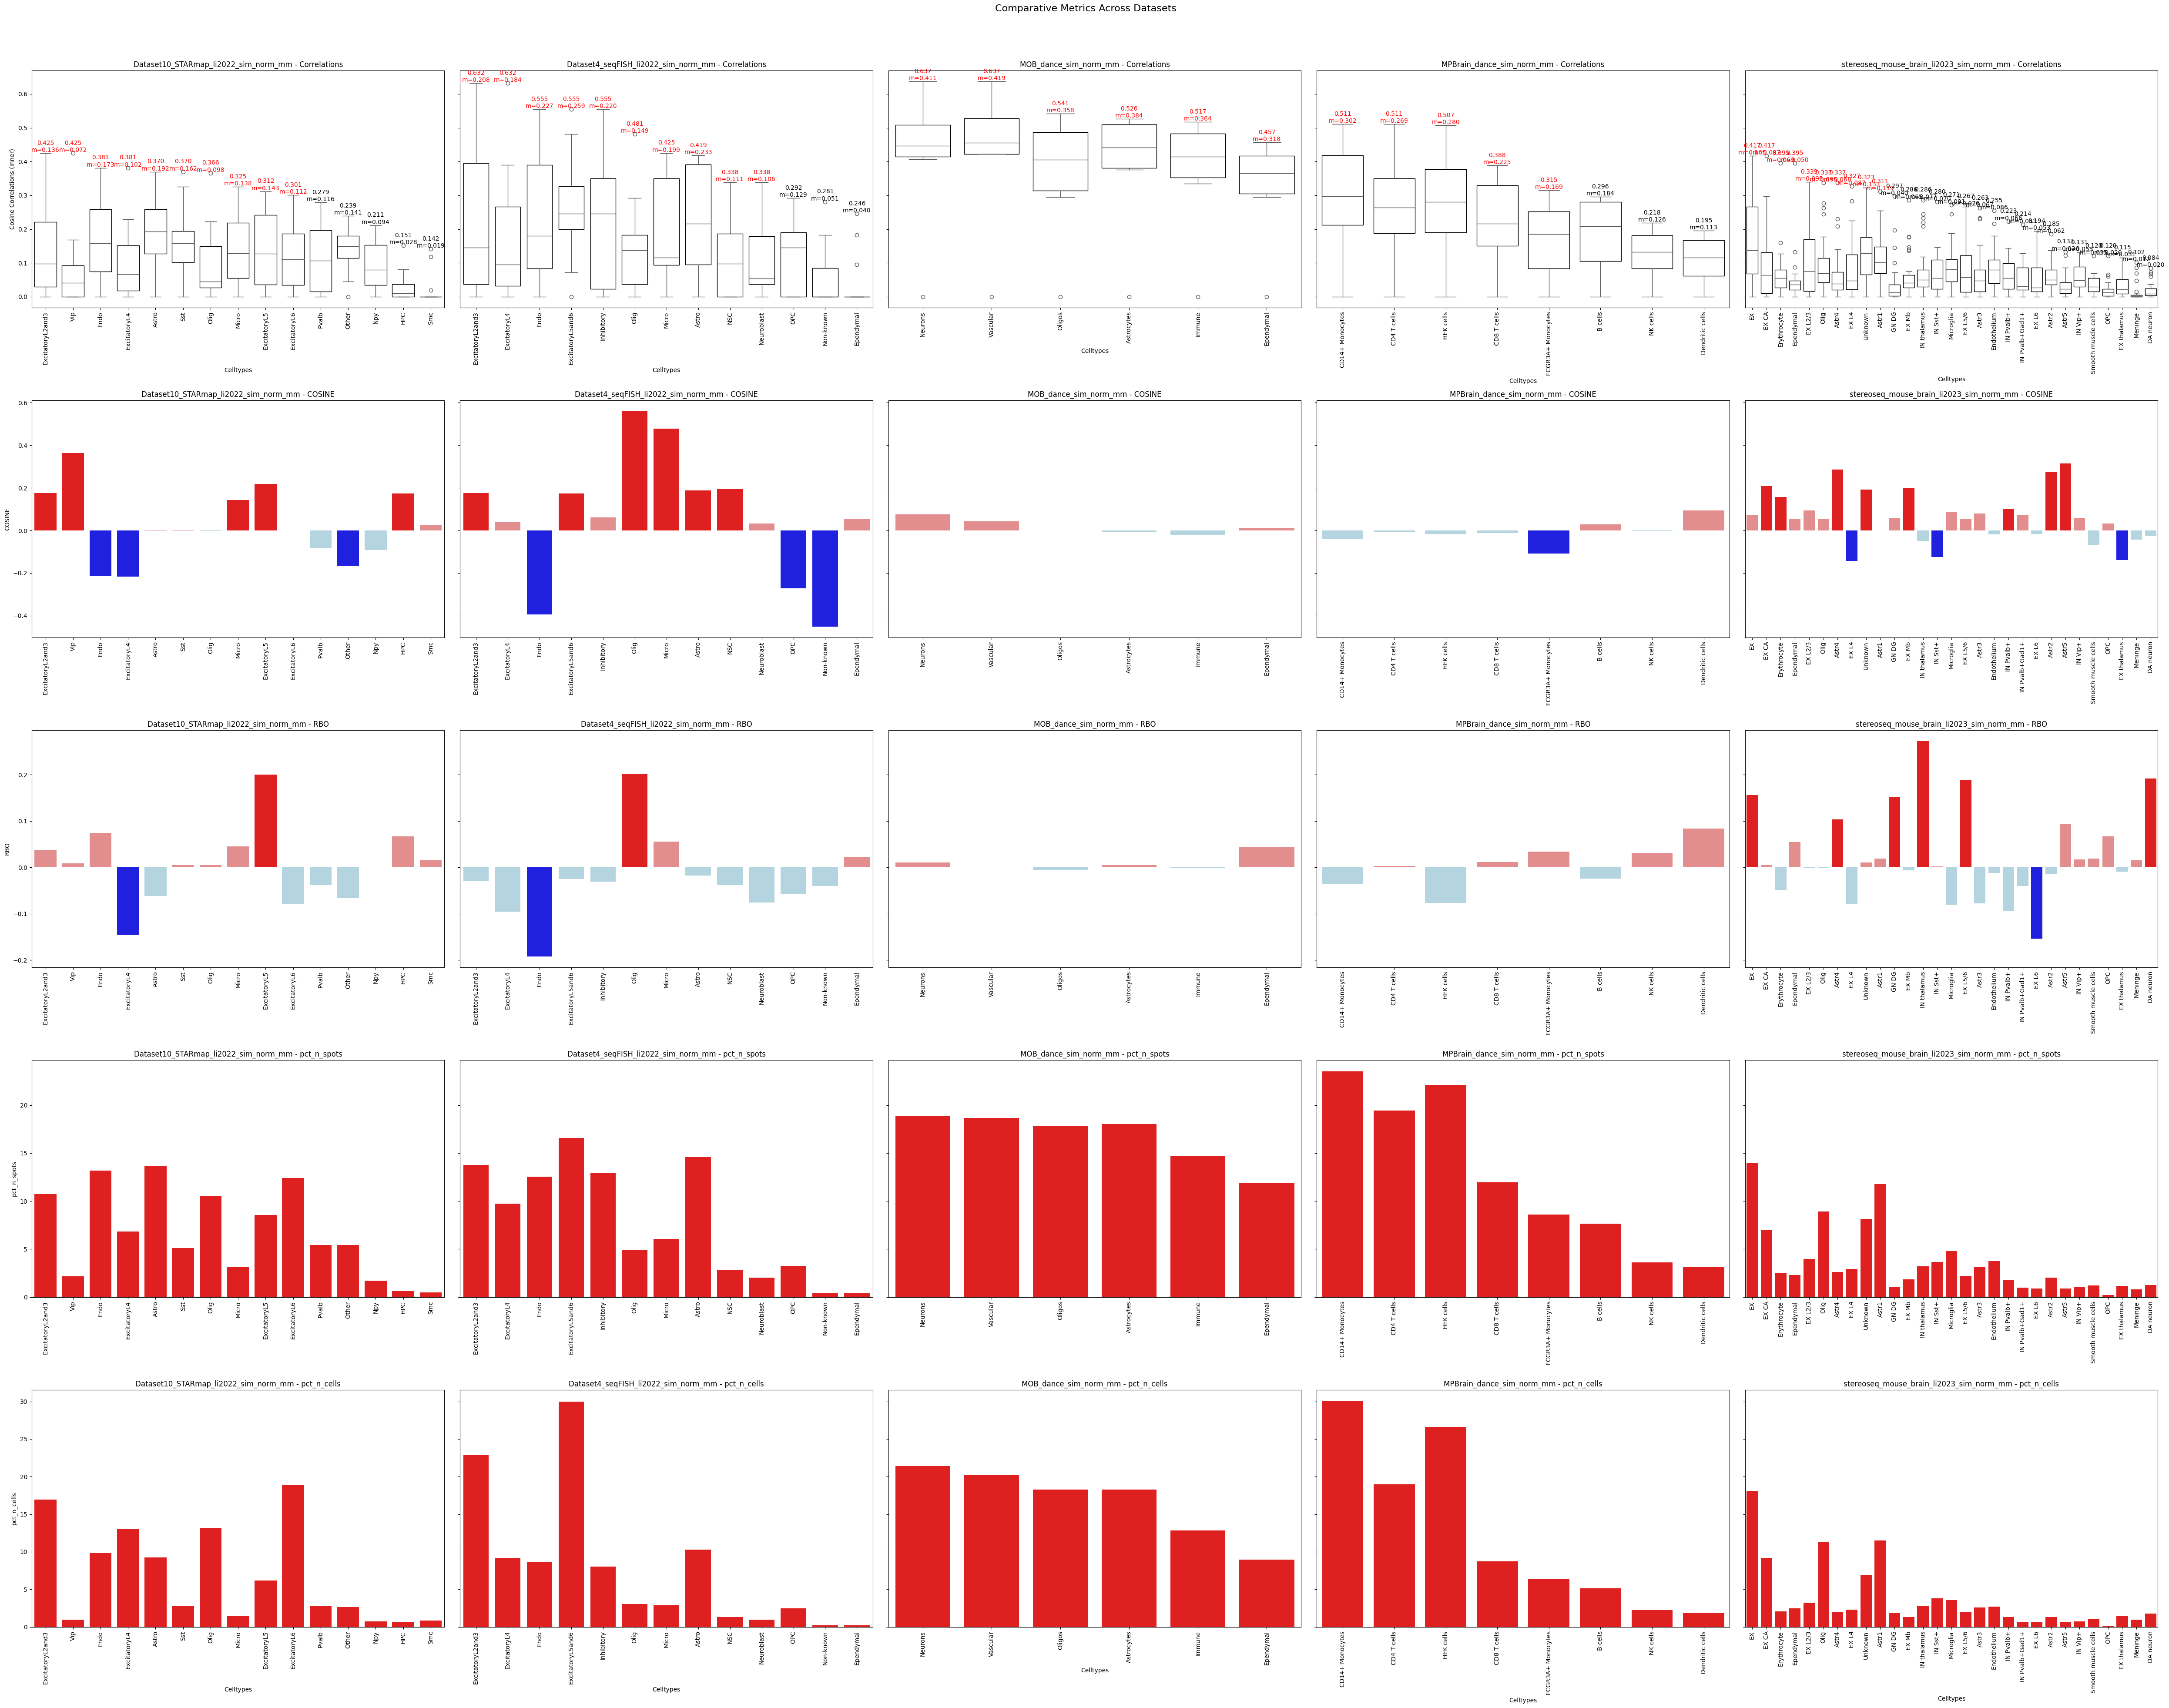

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import matplotlib.patches as patches


# Compute metrics excluding diagonal
def compute_row_metrics(df):
    matrix = df.to_numpy()  # Convert to numpy array for efficient operations
    diag = np.diag(matrix)  # Extract diagonal values
    matrix_wo_diag = matrix - np.diagflat(diag)  # Subtract diagonal elements

    row_sums = matrix_wo_diag.sum(axis=1)  # Row-wise sum
    row_means = matrix_wo_diag.sum(axis=1) / (matrix_wo_diag.shape[1] - 1)  # Row-wise mean
    row_max = np.max(matrix_wo_diag, axis=1)  # Row-wise max
    row_min = np.min(matrix_wo_diag, axis=1) 

    # Combine results into a DataFrame
    return pd.DataFrame({
        "min": row_min,
        "mean": row_means,
        "max": row_max
    }, index=df.index)

correlation_type = "cosine"

# Initialize a dictionary to store aggregated data for all datasets
# aggregated_data = {metric: [] for metric in ['PCC', 'COSINE', 'RMSE', 'JS', 'RBO', 'nDCG', 'AS_S', 'AS_G']}
aggregated_data = {metric: [] for metric in ['COSINE', 'RBO','pct_n_spots','pct_n_cells']}

datasets_metrics = {}

# Initialize variables for determining the global x-axis limits
all_x_vals = []

# Loop through each sample in running_datasets
for sample_name in running_datasets:
    # Load data
    df_corr = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", "correlations", f"{sample_name}_{correlation_type}.csv"), index_col=0)
    np.fill_diagonal(df_corr.values, 0)
    df_metrics = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", f"metrics_{sample_name}.csv"))
    df_sparsity = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", "sparsity_{sample_name}.csv"),index_col=0)

    df_celltypes = compute_row_metrics(df_corr)
    datasets_metrics[sample_name] = df_celltypes

    # Collect all x-values for consistent scaling across datasets
    all_x_vals.extend(df_celltypes.index.tolist())

    # Process the metrics
    for metric in ['COSINE','RBO']:
    # for metric in ['PCC', 'COSINE', 'RMSE', 'JS', 'RBO', 'nDCG', 'AS_S', 'AS_G']:
        df_pivot = df_metrics.pivot(index="celltype", columns="experiment", values=metric)
        df_pivot['Diff'] = df_pivot["ot"] - df_pivot["cnmf"]
        df_celltypes = df_celltypes.reindex(df_pivot.index)
        df_celltypes[f'{metric}'] = df_pivot['Diff']

        aggregated_data[metric].append({
            "dataset": sample_name,
            "data": df_celltypes[[f'{metric}']]
        })

    for metric in df_sparsity.columns:
        aggregated_data[metric].append({
            "dataset": sample_name,
            "data": df_sparsity[[f'{metric}']]
        })


# Set up the figure layout with additional space for the boxplot
num_metrics = len(aggregated_data)
fig, axes = plt.subplots(
    nrows=num_metrics + 1, 
    ncols=len(running_datasets), 
    figsize=(10* len(running_datasets), 8 * (num_metrics + 1)),
    sharex=False,
    sharey='row'
)

sorted_columns_list = []
# Create the first plot (Boxplot for min, mean, max of cosine correlations)
for col_idx, sample_name in enumerate(running_datasets):
    df_corr = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", "correlations", f"{sample_name}_{correlation_type}.csv"), index_col=0)
    np.fill_diagonal(df_corr.values, 0)
    sorted_columns = df_corr.max().sort_values(ascending=False).index
    df_corr = df_corr[sorted_columns]
    sorted_columns_list.append(sorted_columns)


    sns.boxplot(data=df_corr, ax=axes[0, col_idx], palette="Set2", boxprops=dict(facecolor='none', edgecolor='black'))
    # Annotate the maximum value
    for i, column in enumerate(df_corr.columns):
            mean_value = df_corr[column].mean()
            max_value = df_corr[column].max()
            axes[0, col_idx].text(
                i, max_value, f"{max_value:.3f}\nm={mean_value:.3f}",  # format the value to 3 decimal points
                ha="center", va="bottom", fontsize=10, color= 'red' if max_value >=0.3 else "black"
            )
            # if(max_value >=0.3):
            #     # Add the circle above the text
            #     circle = patches.Circle(
            #         (i, max_value + 0.04),  # Position slightly above the text
            #         radius=0.01,            # Radius of the circle
            #         color='red',            # Same color as the text
            #         fill=True
            #     )
            #     axes[0, col_idx].add_artist(circle)


    axes[0, col_idx].set_title(f"{sample_name} - Correlations")
    axes[0, col_idx].set_ylabel("Cosine Correlations (Inner)")
    axes[0, col_idx].set_xlabel("Celltypes")
    axes[0, col_idx].tick_params(axis='x', rotation=90)

# Plot the remaining metrics
for row_idx, (metric, data_list) in enumerate(aggregated_data.items()):
    for col_idx, dataset_data in enumerate(data_list):
        dataset_name = dataset_data["dataset"]
        df_data = dataset_data["data"]
        df_data = df_data.loc[sorted_columns_list[col_idx]]
        ax = axes[row_idx + 1, col_idx]
        # colors = ['red' if value > 0 else 'blue' for value in df_data[f'{metric}']]
        colors = [
        'blue' if value < -0.1 else
        'lightblue' if value < 0 else
        'lightcoral' if value <= 0.1 else
        'red'
        for value in df_data[f'{metric}']
         ]
        
        sns.barplot(
            x=df_data.index, 
            y=df_data[f'{metric}'], 
            ax=ax, 
            palette=colors
        )
        ax.set_title(f"{dataset_name} - {metric}")
        ax.set_ylabel(metric if col_idx == 0 else "")
        ax.set_xlabel("Celltypes" if row_idx == num_metrics - 1 else "")
        ax.tick_params(axis='x', rotation=90)


# Adjust layout
plt.suptitle("Comparative Metrics Across Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save or show the plot
# plt.savefig("aggregated_metrics_plot_with_boxplot.pdf")  # Adjust path as needed
plt.savefig(os.path.join(r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data", "CelltypeStats", f"stats_per_celltype_sorted_mean_density_threshold.pdf"))
plt.show()


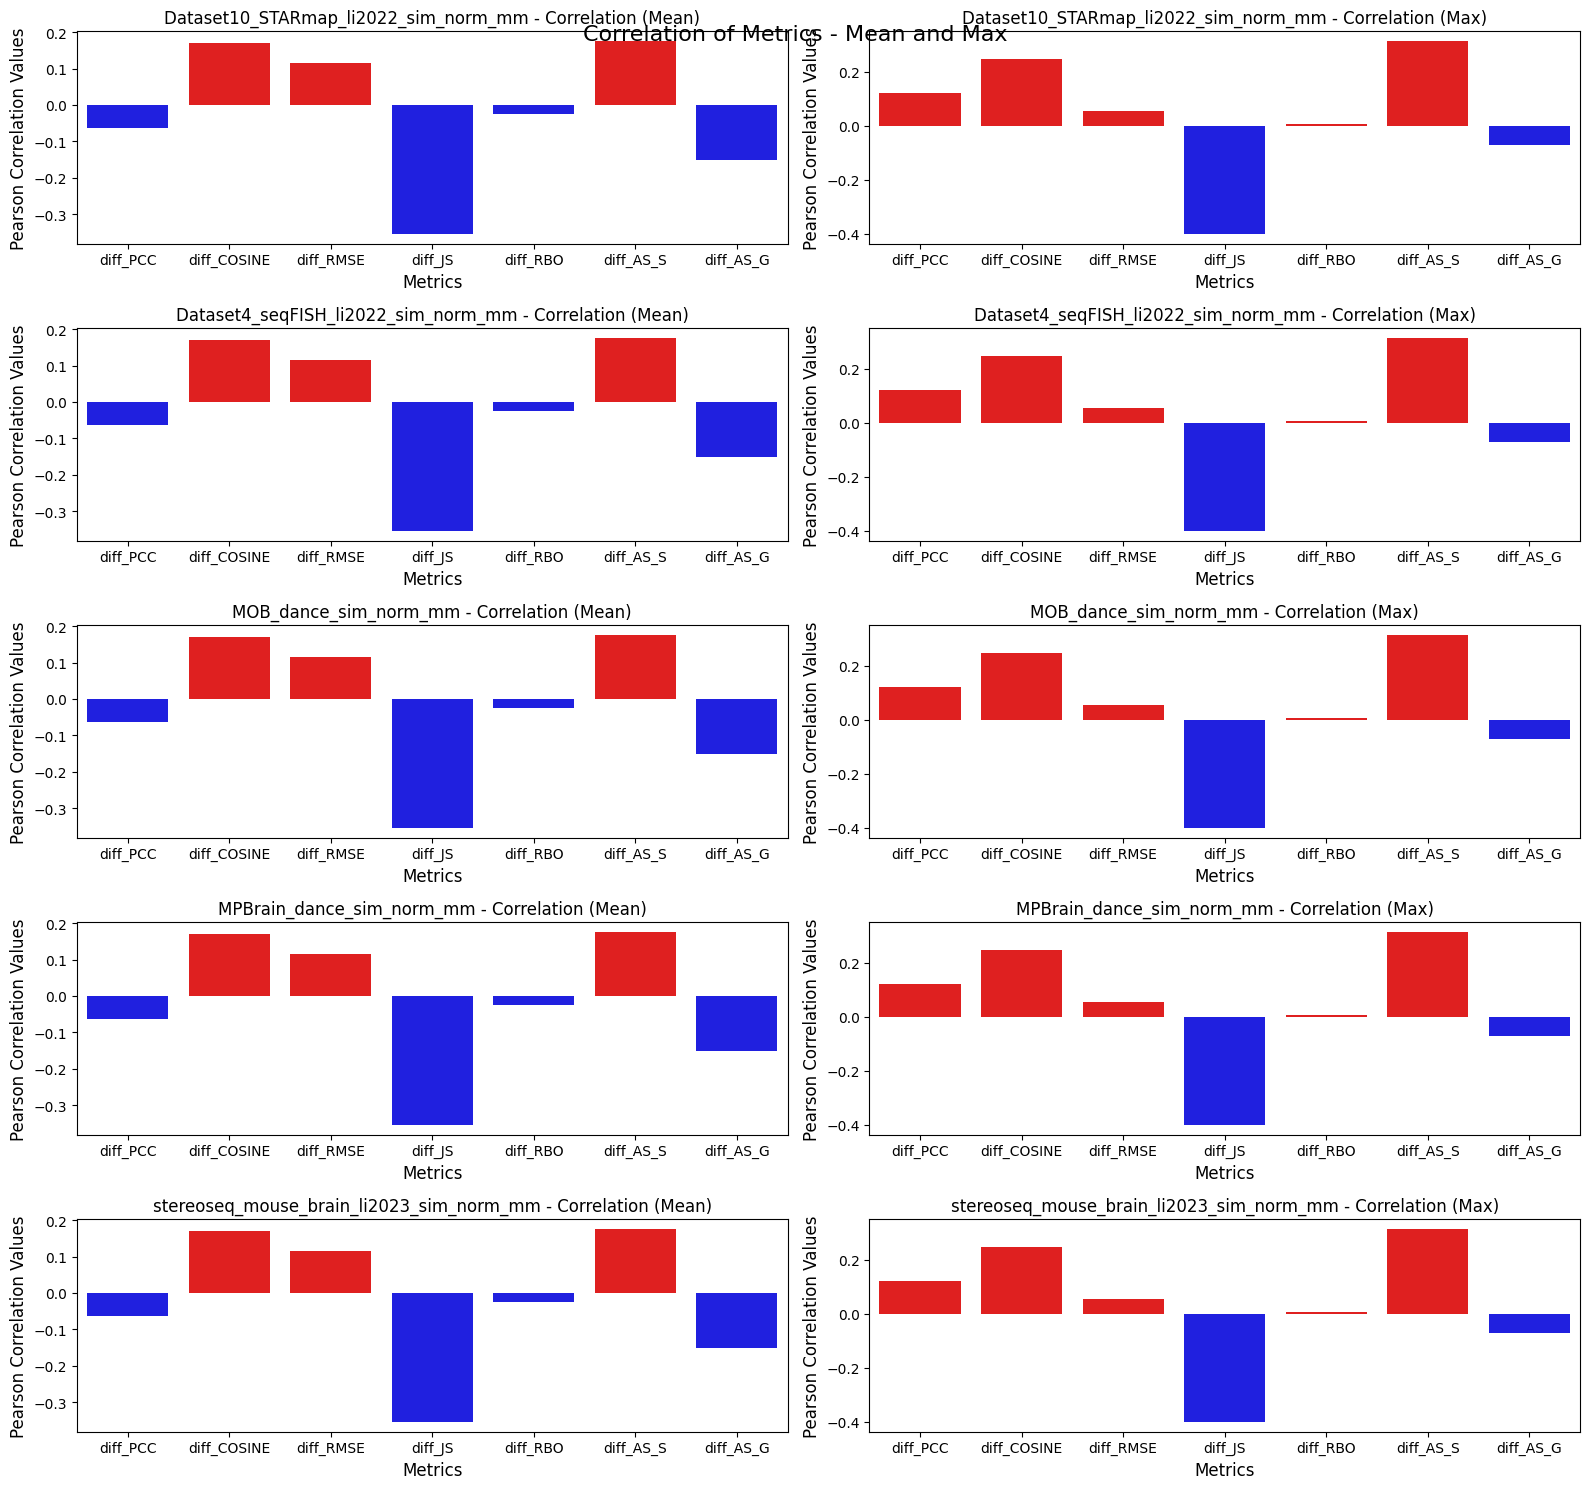

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df_celltypes' is your DataFrame and 'diff_metrics' is the list of metrics
corr_mean = [] 
corr_max = []

# Compute correlations for mean and max
for diff_metric in diff_metrics:
    corr_mean.append(df_celltypes['mean'].corr(df_celltypes[diff_metric]))
    corr_max.append(df_celltypes['max'].corr(df_celltypes[diff_metric]))

# Create subplots
n_datasets = len(running_datasets)  # Number of datasets (rows)
fig, axes = plt.subplots(nrows=n_datasets, ncols=2, figsize=(16, 3 * n_datasets))

# Iterate over datasets to create individual plots
for idx, sample_name in enumerate(running_datasets):
    # Create color palettes for mean and max
    palette_mean = ['red' if 0 <= x else 'blue' for x in corr_mean]
    palette_max = ['red' if 0 <= x else 'blue' for x in corr_max]

    # Plot for mean correlation
    sns.barplot(x=diff_metrics, y=corr_mean, palette=palette_mean, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{sample_name} - Correlation (Mean)', fontsize=12)
    axes[idx, 0].set_xlabel('Metrics', fontsize=12)
    axes[idx, 0].set_ylabel('Pearson Correlation Values', fontsize=12)

    # Plot for max correlation
    sns.barplot(x=diff_metrics, y=corr_max, palette=palette_max, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{sample_name} - Correlation (Max)', fontsize=12)
    axes[idx, 1].set_xlabel('Metrics', fontsize=12)
    axes[idx, 1].set_ylabel('Pearson Correlation Values', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
fig.suptitle("Correlation of Metrics - Mean and Max", fontsize=16)

# Save the figure
plt.savefig(os.path.join(r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data", "CelltypeStats", "correlations_all_datasets.pdf"))

# Display the plot
plt.show()

## Time Analysis

<Figure size 640x480 with 0 Axes>

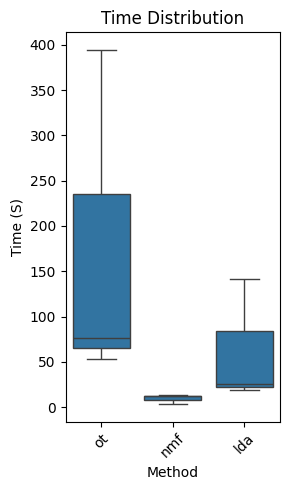

In [12]:
# Dictionary to store results
import matplotlib.pyplot as plt
import seaborn as sns

time_data = []


# Iterate over each dataset and compute metrics
for sample_name in ["Dataset10_STARmap_li2022_sim_norm_mm", "MOB_dance_sim_norm_mm", "Dataset4_seqFISH_li2022_sim_norm_mm"]:
    for method in experiments_list:
        # Construct path and load text file
        time_name_path = os.path.join(results_dir, sample_name, f"{method}_{sample_name}", f"time_{method}_{sample_name}.txt")
        
        # Check if file exists
        if os.path.exists(time_name_path):
            with open(time_name_path, 'r') as file:
                # Read the time value from the text file
                time_value = float(file.read().strip())  # Ensure you get the number
            
            # Append data for seaborn
            time_data.append({'method': method, 'time': time_value})
        else:
            print(f"File not found: {time_name_path}")

# Convert the time data to a DataFrame
df_time = pd.DataFrame(time_data)
df_time = df_time[df_time["method"]!="cnmf"]
df_time = df_time[df_time["method"]!="cot"]


# Plot the time distribution using seaborn
plt.figure(figsize=(3, 5))
sns.boxplot(x='method', y='time', data=df_time)
plt.title('Time Distribution')
plt.ylabel('Time (S)')
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.tight_layout()


plot_dir = tut.process.utils.check_dir(os.path.join(base_dir, "figures"))



plt.savefig(os.path.join(plot_dir, "ismb_time.pdf"))
plt.show()


In [16]:
import psutil
import cpuinfo
import GPUtil

def get_system_info():
    # CPU Information
    cpu_info = cpuinfo.get_cpu_info()
    cpu_name = cpu_info.get("brand_raw", "Unknown CPU")
    cpu_cores = psutil.cpu_count(logical=False)
    cpu_threads = psutil.cpu_count(logical=True)
    
    # Memory Information
    virtual_memory = psutil.virtual_memory()
    total_memory = virtual_memory.total / (1024 ** 3)  # Convert to GB
    
    # GPU Information
    gpus = GPUtil.getGPUs()
    gpu_details = []
    for gpu in gpus:
        gpu_details.append({
            "name": gpu.name,
            "total_memory": f"{gpu.memoryTotal} MB",
            "free_memory": f"{gpu.memoryFree} MB",
            "used_memory": f"{gpu.memoryUsed} MB"
        })
    
    # Print Results
    print(f"CPU: {cpu_name}")
    print(f"Cores: {cpu_cores}, Threads: {cpu_threads}")
    print(f"Total Memory: {total_memory:.2f} GB")
    
    if gpu_details:
        print("\nGPU Details:")
        for idx, gpu in enumerate(gpu_details):
            print(f"  GPU {idx}: {gpu['name']}")
            print(f"    Total Memory: {gpu['total_memory']}")
            print(f"    Free Memory: {gpu['free_memory']}")
            print(f"    Used Memory: {gpu['used_memory']}")
    else:
        print("No GPU found.")

# Call the function
get_system_info()

CPU: 11th Gen Intel(R) Core(TM) i7-11700F @ 2.50GHz
Cores: 8, Threads: 16
Total Memory: 31.68 GB

GPU Details:
  GPU 0: NVIDIA GeForce RTX 3080
    Total Memory: 10240.0 MB
    Free Memory: 8551.0 MB
    Used Memory: 1503.0 MB


## Hyperparamters Optimization

In [ ]:
import os 
import pandas as pd 
import scanpy as sc 
import sys
import optuna
import numpy as np
sys.path.append('..')
from Wassgard import models, hvg, eval


base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
data_dir = os.path.join(base_dir, "data")

dataset = "MOB_dance_sim_norm_mm"

if(dataset == "stereoseq_mouse_brain_li2023_sim_norm_mm"):
    steroseq_dataset_path = os.path.join(data_dir, dataset)              
    adata_spatial = tut.process.io.get_xeno_spatial_data(steroseq_dataset_path, sample_name=dataset)
else:
    dataset_path = os.path.join(data_dir, dataset)
    adata_spatial = sc.read_h5ad(os.path.join(dataset_path, "adata_spatial.h5ad"))

adata_spatial, overdispersed_genes = hvg.compute_overdispersed_genes(adata_spatial, save_dir=None, is_show=False)

k = len(adata_spatial.uns["ground_truth"].columns) 
ground_truth= adata_spatial.uns["ground_truth"]
ground_truth.index = ground_truth.index.map(str)

# Define the objective function for optimization
def objective(trial):
    # Model parameters
    kwags = {
        "h": trial.suggest_float("h", 0.00001, 0.5),
        "w": trial.suggest_float("w", 0.00001, 0.5),
        "eps": trial.suggest_float("eps", 0.00001, 0.5),
        "lr": trial.suggest_float("lr", 0.00001, 0.5),
        # "cost": "cosine",  
        # "normalize_rows": "False",
        # "optim_name": "adam",  
        # "tol_inner": trial.suggest_float("tol_inner", 1e-14, 1e-10, log=True),
        # "tol_outer": trial.suggest_float("tol_outer", 1e-5, 1e-3, log=True),
    }


    results, losses = models.run_wassgard(adata_spatial, components=k, **kwags)

    spots_df = results['topics_per_spot']
    df_corr = eval.annotate_programs_by_ground_truth(spots_df,  ground_truth, correlation_type = 'cosine', top_n_features = 500)
    df_annotation = eval.get_annotation_from_corr(df_corr)
    df_annotation = df_annotation.sort_values(by='celltype')
    df_reordered = df_corr[df_annotation['celltype'].values]
    df_reordered = df_reordered.reindex(df_annotation['program'].values).T

    diagonal_values = np.diag(df_reordered)
    corr_score = np.mean(diagonal_values)

    return corr_score, np.abs(losses[-1])


storage_url = "sqlite:///optuna_study_wassgard.db"  # Replace with your storage URL (e.g., SQLite database)

search_space = {
    'h': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
    "w": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
    "eps": [0.005, 0.01, 0.05, 0.1, 0.5],
    "lr":[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
}

# Start the optimization process
study_name = f"wassgard_{dataset}"  # Replace with your study name

study = optuna.create_study(study_name=study_name,
                            storage =storage_url,
                            load_if_exists=True,
                            sampler=optuna.samplers.GridSampler(search_space),
                            directions=["maximize", "minimize"])  # Use "maximize" if higher is better

study.optimize(objective, n_trials=100, show_progress_bar=True)


In [2]:
import os 
import pandas as pd 
import scanpy as sc 
import sys
import optuna

running_datasets = ["Dataset10_STARmap_li2022_sim_norm_mm", "Dataset4_seqFISH_li2022_sim_norm_mm", "MPBrain_dance_sim_norm_mm", "MOB_dance_sim_norm_mm", "stereoseq_mouse_brain_li2023_sim_norm_mm"]

storage_url = "sqlite:///optuna_study_wassgard.db"  # Replace with your storage URL (e.g., SQLite database)

study_name = f"wassgard_{dataset}"  # Replace with your study name

dfs = []
for dataset in running_datasets:
    study = optuna.load_study(study_name=study_name, storage=storage_url)

    df = study.trials_dataframe()
    df = df.set_index('number')
    df['best_trails'] = 0
    df['selected'] = 0
    best_trial = find_best_trial(dataset)
    df.loc[best_trial.number, 'selected'] = 1
    best_trails = study.best_trials

    for trial in best_trails:
        df.loc[trial.number, 'best_trails'] = 1

    df['dataset'] = dataset
    df = df.reset_index()
    dfs.append(df)

dfs = pd.concat(dfs)



# output_file = r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Tables\optuna_hyperparameters.csv"
# dfs.to_csv(output_file)


NameError: name 'find_best_trial' is not defined

## Stability 

In [2]:
import os 
import pandas as pd 
import scanpy as sc 
import sys
import optuna
import numpy as np
sys.path.append('..')
from Wassgard import models, hvg, eval
import tqdm
from TUT import tut


base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
data_dir = os.path.join(base_dir, "data")


dataset = "Dataset10_STARmap_li2022_sim_norm_mm"

dataset_path = os.path.join(data_dir, dataset)
adata_spatial = sc.read_h5ad(os.path.join(dataset_path, "adata_spatial.h5ad"))
for key in adata_spatial.uns["paths"]:
    adata_spatial.uns["paths"][key] = adata_spatial.uns["paths"][key].replace("D:", "Z:")

adata_spatial, overdispersed_genes = hvg.compute_overdispersed_genes(adata_spatial, save_dir=None, is_show=False)

k = len(adata_spatial.uns["ground_truth"].columns) 
ground_truth= adata_spatial.uns["ground_truth"]
ground_truth.index = ground_truth.index.map(str)


# best_trial = find_best_trial(dataset)
# kwags = best_trial.params

stability = []

for i in tqdm.tqdm(range(100)):
    # results_dir_path = tut.process.utils.check_dir(os.path.join(base_dir, "stdecon_stability", f"trail_{i}"))
    # results = tut.models.ptm.run_stdeconvolve(adata_spatial, results_dir_path, sample_name, str(k), nprocess="16")
    # results, losses = models.run_wassgard(adata_spatial, components=k, **kwags)
    results = tut.models.cnmf.run_nmf(adata_spatial, k)

    # results = tut.models.cnmf.run_cnmf(adata_spatial, components=[k], n_genes=2000, nprocess=1, n_iter=50, density_threshold=0.1)
    

    spots_df = results['topics_per_spot']
    df_corr = eval.annotate_programs_by_ground_truth(spots_df,  ground_truth, correlation_type = 'cosine', top_n_features = 500)
    df_annotation = eval.get_annotation_from_corr(df_corr)
    df_annotation = df_annotation.sort_values(by='celltype')
    df_reordered = df_corr[df_annotation['celltype'].values]
    df_reordered = df_reordered.reindex(df_annotation['program'].values).T

    diagonal_values = np.diag(df_reordered)
    corr_score = np.mean(diagonal_values)
    # stability.append([i, corr_score, np.abs(losses[-1])])
    stability.append([i, corr_score])


df = pd.DataFrame(stability)
df.to_csv("nmf_stability.csv")


Selecting Genes with alpha 0.05 and use_unadjusted_pvals True is_spatial False
Initial data: 189 spots, 882 genes
Spots after filtering: 189
Genes after filtering: 882
Using GAM model with k=5 ...
Identified 108 overdispersed genes.


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


In [ ]:
df = pd.read_excel('file.xlsx')

# Group by 'method' and calculate variance and mean for 'metric'
grouped_stats = df.groupby('method')['metric'].agg(['var', 'mean'])

## Gene Selection

In [5]:
results_dir = tut.process.utils.check_dir(os.path.join(base_dir, "HVG_Selection"))
running_datasets = ["Dataset10_STARmap_li2022_sim_norm_mm", "Dataset4_seqFISH_li2022_sim_norm_mm", "MOB_dance_sim_norm_mm", "stereoseq_mouse_brain_li2023_sim_norm_mm"]
running_experiments = ["ot"]
for is_spatial in [True, False]:
    alpha_list = [0.05] if is_spatial else [0.05, 0.1, 0.15]
    adjusted_list = [True] if is_spatial else [False, True]
    for alpha in alpha_list:
        for adjusted in adjusted_list:
            kwargs = {
                'alpha': alpha,
                'use_unadjusted_pvals' : adjusted,
                'is_spatial': is_spatial
            }

            experiment_version = "_".join([f"{key}_{value}" for key, value in kwargs.items()])

            for dataset in running_datasets:
                print(f"Starting {dataset}")

                if(dataset == "stereoseq_mouse_brain_li2023_sim_norm_mm"):
                    steroseq_dataset_path = os.path.join(data_dir, dataset)              
                    adata_spatial = tut.process.io.get_xeno_spatial_data(steroseq_dataset_path, sample_name=dataset)
                else:
                    dataset_path = os.path.join(data_dir, dataset)
                    adata_spatial = sc.read_h5ad(os.path.join(dataset_path, "adata_spatial.h5ad"))


                sample_name = adata_spatial.uns["dataset_name"]
                print(sample_name, adata_spatial.X.shape)

                adata_spatial.uns["params"]=dataset_list[dataset]
                best_trial = find_best_trial(dataset)
                adata_spatial.uns["params"]["ot"] = best_trial.params

                for key in adata_spatial.uns["paths"]:
                    adata_spatial.uns["paths"][key] = adata_spatial.uns["paths"][key].replace("D:", "Z:")
                    
                """Run experiments and annotations for a given adata."""
                for exp_name in running_experiments:
                    print(sample_name, exp_name)
                    k = len(adata_spatial.uns["ground_truth"].columns) 
                    tut.run_experiment(adata_spatial.copy(), k, sample_name, exp_name,
                                        results_dir = os.path.join(results_dir, sample_name, experiment_version), filter_genes=True, **kwargs)

                    tut.annotate.annotate_with_benchmark(sample_results_dir = os.path.join(results_dir, sample_name, experiment_version), adata_spatial = adata_spatial, exp_name=exp_name, correlation_type = 'cosine', top_n_features = 500)


In [103]:
import pandas as pd 
import os
import scanpy as sc 
import sys
sys.path.append('..')
from TUT import tut

running_experiments = ['ot']
base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
data_dir = os.path.join(base_dir, "data")

running_datasets = ["Dataset10_STARmap_li2022_sim_norm_mm", "Dataset4_seqFISH_li2022_sim_norm_mm", "MOB_dance_sim_norm_mm", "stereoseq_mouse_brain_li2023_sim_norm_mm", "Synthetic_Spotlight"]
results_dir = tut.process.utils.check_dir(os.path.join(base_dir, "ismb_svg_results"))

save_dir = r'Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data\HVGSelection'


# for dataset in running_datasets:
#     print(f"Starting {dataset}")
#     if(dataset == "stereoseq_mouse_brain_li2023_sim_norm_mm"):
#         steroseq_dataset_path = os.path.join(data_dir, dataset)              
#         adata_spatial = tut.process.io.get_xeno_spatial_data(steroseq_dataset_path, sample_name=dataset)
#     else:
#         dataset_path = os.path.join(data_dir, dataset)
#         adata_spatial = sc.read_h5ad(os.path.join(dataset_path, "adata_spatial.h5ad"))
#     sample_name = adata_spatial.uns["dataset_name"]
#     print(sample_name, adata_spatial.X.shape)
#     adata_spatial.uns["params"]=dataset_list[dataset]


#     results_df = []
#     keys= []
#     for svg_experiment in os.listdir(os.path.join(results_dir, dataset)):
#         print(svg_experiment)
#         for exp_name in running_experiments:
#             r_df = tut.benchmark.benchmark.benchmark_results(
#                         os.path.join(results_dir, dataset, svg_experiment, f"{exp_name}_{dataset}"),
#                         adata_spatial,
#                         sample_name=sample_name,
#                         exp_name=exp_name,
#             )
#             results_df.append(r_df)
#             keys.append(f"{svg_experiment.replace("_use_unadjusted_pvals_","").replace("alse","").replace("rue","")}_{exp_name}")
#     dfs = pd.concat(results_df, keys=keys, names=["experiment", "celltype"])

#     # dfs.to_csv(os.path.join(save_dir, f"metrics_ot_{dataset}.csv"), header=True)

In [130]:
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from upsetplot import from_contents, UpSet

for dataset in running_datasets:
    dfs = pd.read_csv(os.path.join(save_dir, f"metrics_ot_{dataset}.csv"))

    data_genes = {}
    for svg_experiment in os.listdir(os.path.join(results_dir, dataset)):
        experiment_path = os.path.join(results_dir, dataset, svg_experiment, f"ot_{dataset}")
        if(os.path.isdir(experiment_path)):
            df_genes = pd.read_csv(os.path.join(experiment_path, f"gene_stats_ot_{dataset}.csv"),index_col=0)
            data_genes[f"{svg_experiment.replace("_use_unadjusted_pvals_","").replace("alse","").replace("rue","")}"] = df_genes[df_genes['is_odg'] == True].index.values.tolist()
            
    metric = "COSINE"

    # # Pivot the DataFrame to create a matrix format for the heatmap
    # heatmap_data = dfs.pivot(index="experiment", columns="celltype", values=metric)
    # row_averages = heatmap_data.mean(axis=1)
    # row_counts_above_threshold = (heatmap_data > 0.5).sum(axis=1)
    # fig, axes = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1, 4]})
    # axes[0].barh(row_averages.index, row_averages, color='gray', edgecolor='black', height=0.8)
    # axes[0].set_title(f"Average {metric}")
    # axes[0].set_xlabel("Value")
    # axes[0].invert_yaxis()
    # for i, val in enumerate(row_averages):
    #     axes[0].text(val + 0.01, i, f"{val:.2f}", va='center', fontsize=8)

    # # Plot 2: Bar plot of counts of values > 0.5
    # axes[1].barh(row_counts_above_threshold.index, row_counts_above_threshold, color='blue', edgecolor='black', height=0.8)
    # axes[1].set_title(f"Counts > 0.5")
    # axes[1].set_xlabel("Count")
    # axes[1].invert_yaxis()
    # for i, val in enumerate(row_counts_above_threshold):
    #     axes[1].text(val + 0.01, i, f"{val:.0f}", va='center', fontsize=8)

    # # Plot 3: Heatmap
    # sns.heatmap(
    #     heatmap_data,
    #     annot=True,
    #     fmt=".1f",
    #     cmap="coolwarm",
    #     cbar_kws={'label': metric},
    #     annot_kws={"size": 8},
    #     ax=axes[2]
    # )
    # axes[2].set_title(f"Heatmap of {metric}")


    # # Adjust layout and show
    # plt.tight_layout()
    # fig.suptitle(f"Analysis HVG Selection of {metric} {dataset}", y=1.02)
    # fig.savefig(os.path.join(save_dir, f"heatmap_metrics_{dataset}.pdf"))
    # plt.show()



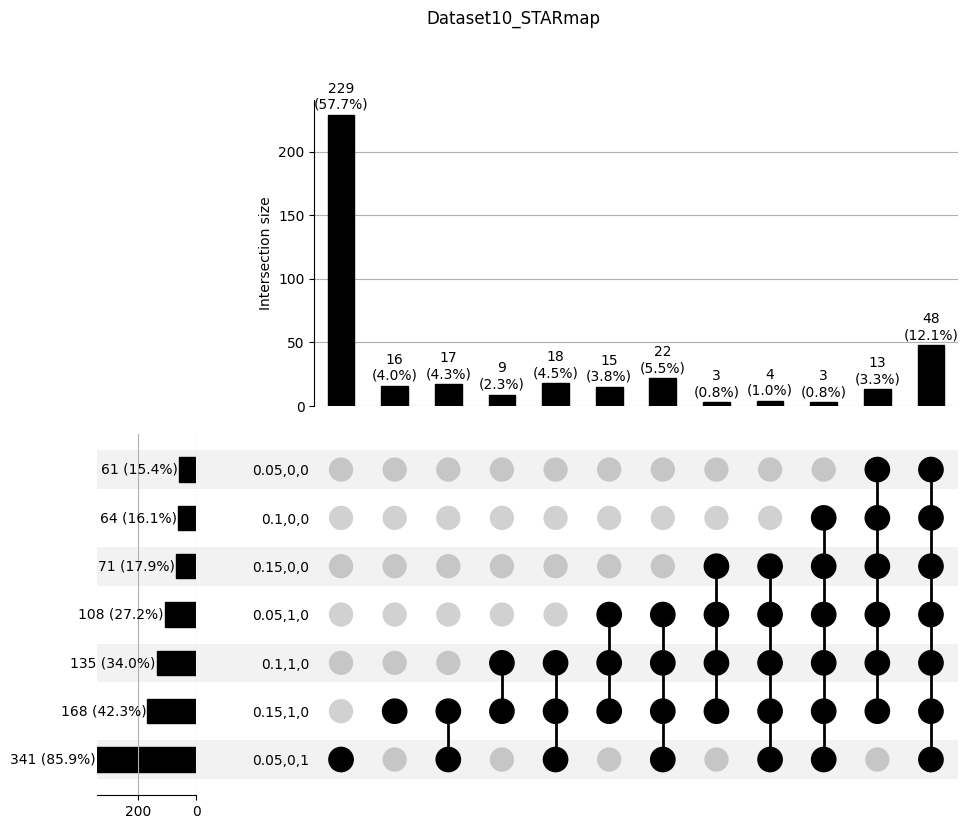

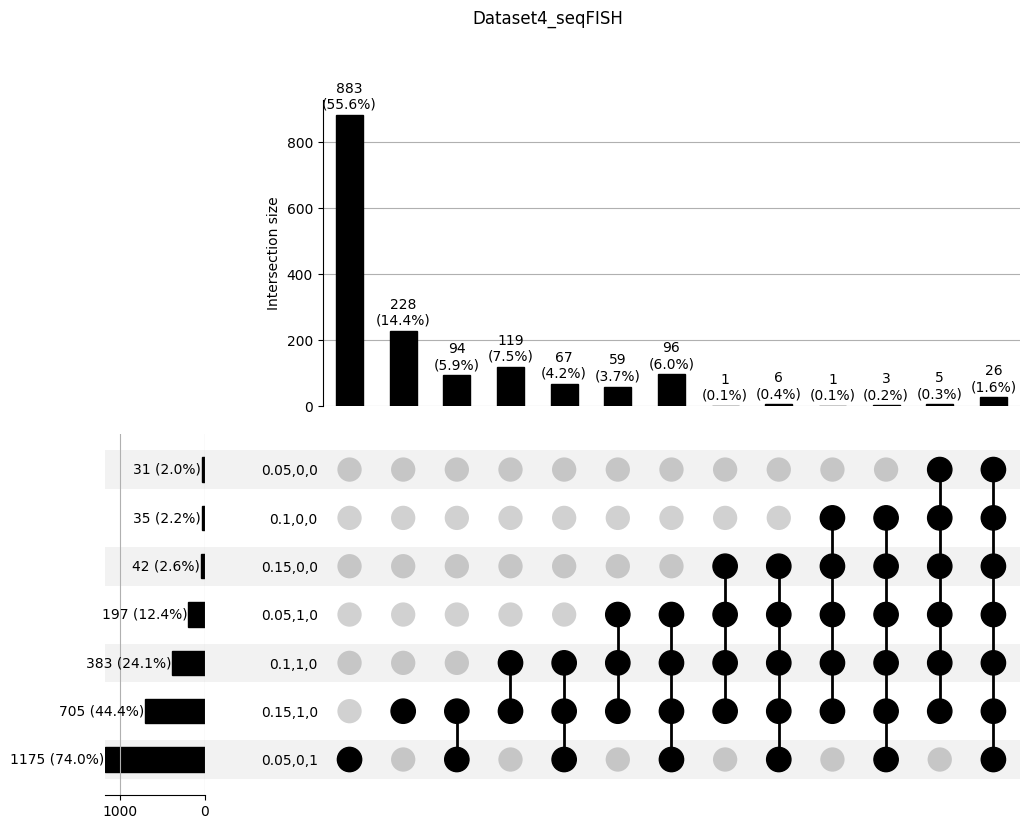

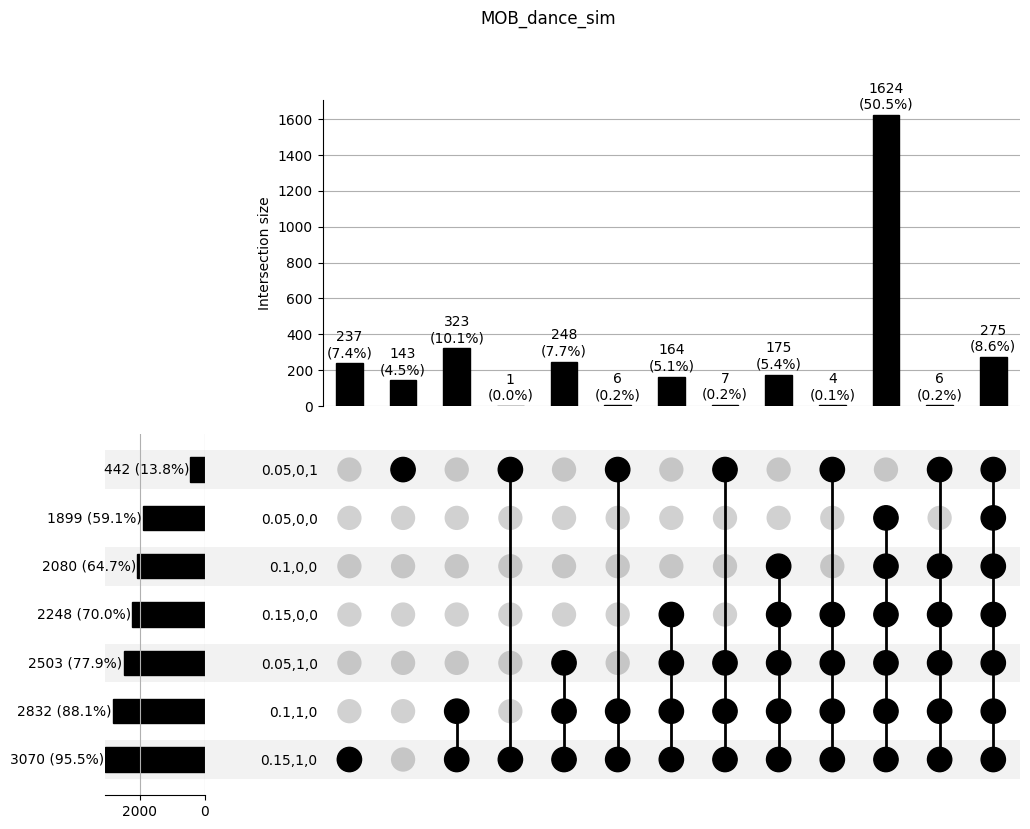

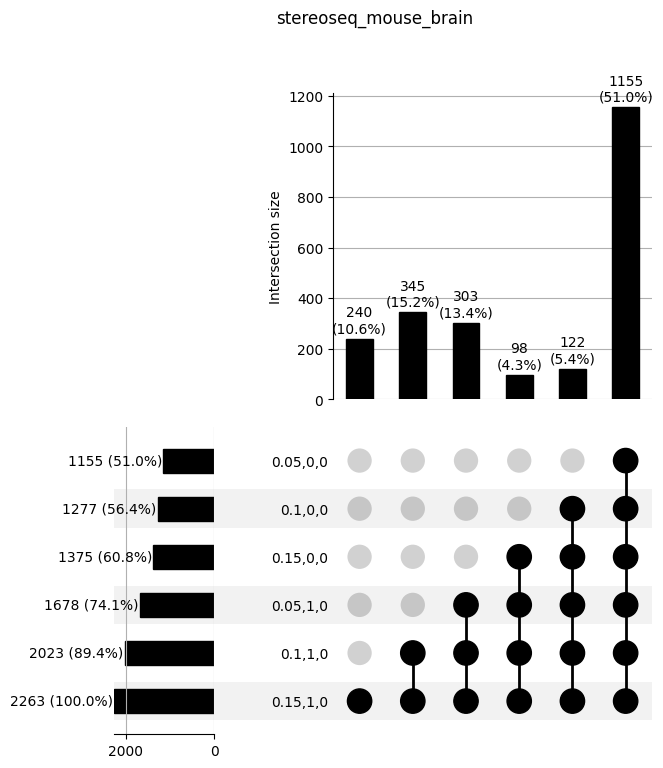

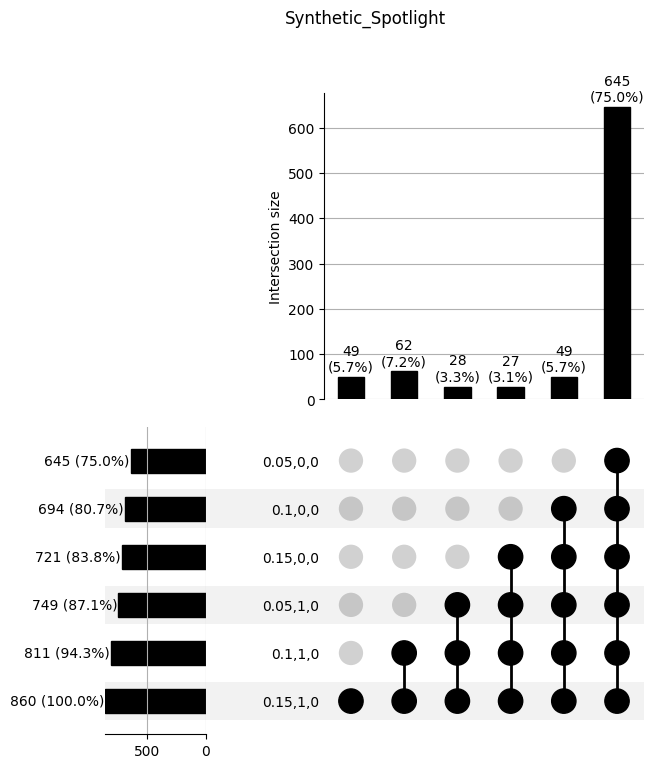

In [129]:
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from upsetplot import from_contents, UpSet

for dataset in running_datasets:
    dfs = pd.read_csv(os.path.join(save_dir, f"metrics_ot_{dataset}.csv"))

    data_genes = {}
    for svg_experiment in os.listdir(os.path.join(results_dir, dataset)):
        experiment_path = os.path.join(results_dir, dataset, svg_experiment, f"ot_{dataset}")
        if(os.path.isdir(experiment_path)):
            df_genes = pd.read_csv(os.path.join(experiment_path, f"gene_stats_ot_{dataset}.csv"),index_col=0)
            new_name = f"{svg_experiment.replace("_use_unadjusted_pvals_","").replace("alse","").replace("rue","").replace("alpha_","").replace("_is_spatial_",",").replace("F,F",",0,0").replace("F,T",",0,1").replace("T,T",",1,1").replace("T,F",",1,0")}"
            data_genes[new_name] = df_genes[df_genes['is_odg'] == True].index.values.tolist()

    # Create UpSet plot
    fig = plt.figure(figsize=(10, 8))
    upset_data = from_contents(data_genes)
    upset = UpSet(upset_data, show_counts="%d", show_percentages=True, element_size=50)
    fig.suptitle(f"{dataset.replace("_li2023_sim_norm_mm","").replace("_li2022_sim_norm_mm","").replace("_norm_mm","")}", fontsize=12)
    upset.plot(fig)
    fig.savefig(os.path.join(save_dir, f"upset_hvg_{dataset}.pdf"))
    plt.show()



C:\Users\alyos\AppData\Local\Temp\ipykernel_27004\3527253034.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='COSINE_Group', y='pct_n_cells', data=df_merged, palette='Set2', ax=axes[i, 0])
C:\Users\alyos\AppData\Local\Temp\ipykernel_27004\3527253034.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='COSINE_Group', y='pct_n_spots', data=df_merged, palette='Set2', ax=axes[i, 1])
C:\Users\alyos\AppData\Local\Temp\ipykernel_27004\3527253034.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='COSINE_Group', y='max_admixture', d

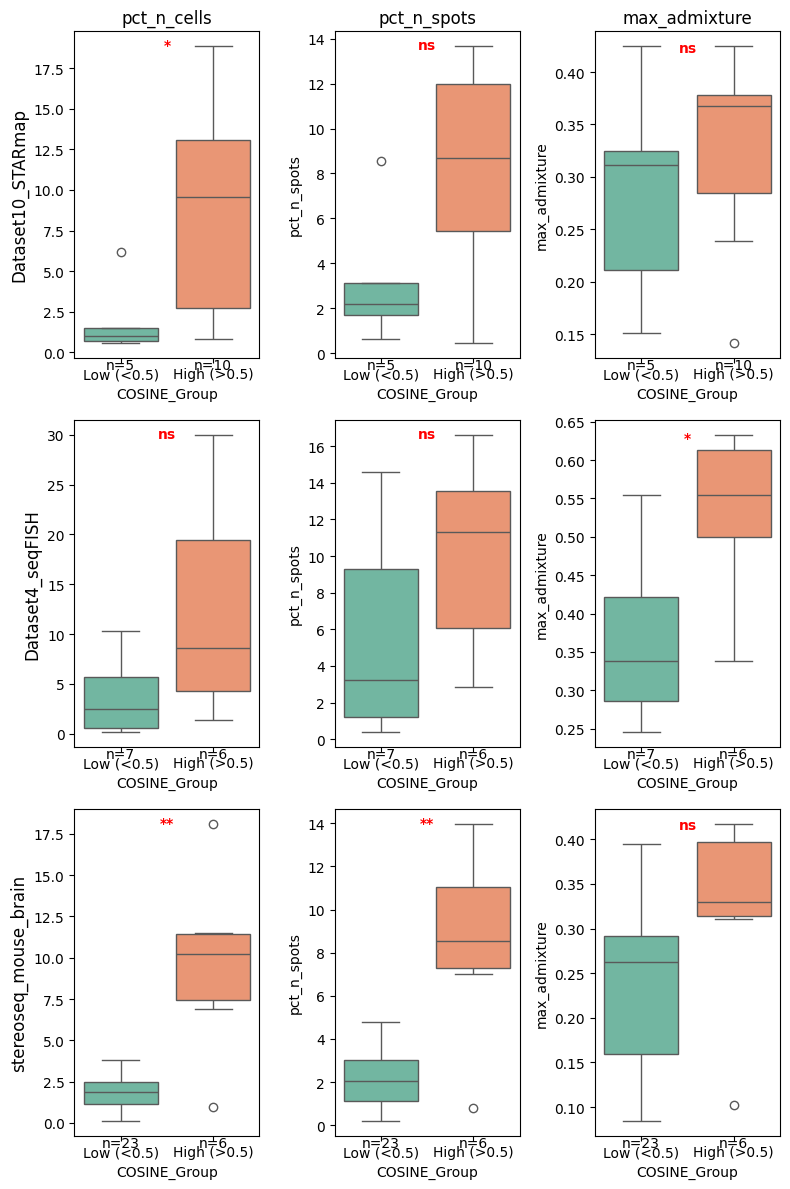

Saved all figures to Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data\HVGSelection\twogroups_stats_all_datasets.pdf


In [2]:
import pandas as pd 
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from scipy.stats import ttest_ind


def add_n_annotations(ax, data, x_col, y_col):
    """ Add 'n' annotations for each category in the boxplot """
    counts = data[x_col].value_counts().to_dict()
    for category, count in counts.items():
        ax.text(
            x=list(data[x_col].cat.categories).index(category), 
            y=data[y_col].min() - (data[y_col].max() - data[y_col].min()) * 0.05, 
            s=f"n={count}",
            ha='center', va='top', fontsize=10, color='black'
        )


def add_stat_annotation(ax, data, x_col, y_col):
    group1 = data[data[x_col] == 'Low (<0.5)'][y_col].dropna()
    group2 = data[data[x_col] == 'High (>0.5)'][y_col].dropna()

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    # stat, p_value = ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
    # Define significance thresholds
    if p_value < 0.0001:
        stars = "****"
    elif p_value < 0.001:
        stars = "***"
    elif p_value < 0.01:
        stars = "**"
    elif p_value < 0.05:
        stars = "*"
    else:
        stars = "ns"  # Not significant

    # Add annotation with stars
    ax.text(0.5, max(data[y_col]) * 0.98, stars, 
            ha='center', va='bottom', fontsize=10, color='red', fontweight='bold')



base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
save_dir = r'Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data\HVGSelection'

results_dir = os.path.join(base_dir, "HVG_Selection")


running_datasets = ["Dataset10_STARmap_li2022_sim_norm_mm", "Dataset4_seqFISH_li2022_sim_norm_mm",
                    #  "MOB_dance_sim_norm_mm", 
                    # "Synthetic_Spotlight",
                     "stereoseq_mouse_brain_li2023_sim_norm_mm"]


running_experiments = ["ot"]

metric = "COSINE"
correlation_type = "cosine"
svg = "alpha_0.05_use_unadjusted_pvals_False_is_spatial_False"

th = 0.5



pdf_path = os.path.join(save_dir, "twogroups_stats_all_datasets.pdf")

with PdfPages(pdf_path) as pdf:
    # Create figure with one row per dataset
    fig, axes = plt.subplots(len(running_datasets), 3, figsize=(8, 4 * len(running_datasets)))

    if len(running_datasets) == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure axes is always 2D

    for i, dataset in enumerate(running_datasets):
        dfs = pd.read_csv(os.path.join(save_dir, f"metrics_ot_{dataset}.csv"))
        svg_name = f"{svg.replace('_use_unadjusted_pvals_', '').replace('alse', '').replace('rue', '')}_ot"
        dfs = dfs[dfs["experiment"] == svg_name]
        dfs.set_index("celltype", inplace=True)
        dfs = dfs[["COSINE"]]

        df_sparsity = pd.read_csv(os.path.join(base_dir, "ismb_results_wassgard", dataset, "analysis", "sparsity_{sample_name}.csv"), index_col=0)
        df_corr = pd.read_csv(os.path.join(base_dir, "ismb_results_wassgard", dataset, "analysis", "correlations", f"{dataset}_{correlation_type}.csv"), index_col=0)
        np.fill_diagonal(df_corr.values, 0)

        # Merge dataframes
        df_merged = df_sparsity.copy()
        df_merged['COSINE'] = dfs['COSINE']
        df_merged['max_admixture'] = df_corr.max(axis=1)
        df_merged['COSINE_Group'] = df_merged['COSINE'].apply(lambda x: f'High (>{th})' if x > th else f'Low (<{th})')
        df_merged['COSINE_Group'] = pd.Categorical(df_merged['COSINE_Group'], categories=['Low (<0.5)', 'High (>0.5)'], ordered=True)

        # Titles
        if i == 0:
            axes[i, 0].set_title('pct_n_cells')
            axes[i, 1].set_title('pct_n_spots')
            axes[i, 2].set_title('max_admixture')

        # Boxplots
        sns.boxplot(x='COSINE_Group', y='pct_n_cells', data=df_merged, palette='Set2', ax=axes[i, 0])
        axes[i, 0].set_ylabel(dataset.replace("_li2023_sim_norm_mm","").replace("_li2022_sim_norm_mm",""), fontsize=12)
        add_stat_annotation(axes[i, 0], df_merged, 'COSINE_Group', 'pct_n_cells')
        add_n_annotations(axes[i, 0], df_merged, 'COSINE_Group', 'pct_n_cells')

        sns.boxplot(x='COSINE_Group', y='pct_n_spots', data=df_merged, palette='Set2', ax=axes[i, 1])
        add_stat_annotation(axes[i, 1], df_merged, 'COSINE_Group', 'pct_n_spots')
        add_n_annotations(axes[i, 1], df_merged, 'COSINE_Group', 'pct_n_spots')

        sns.boxplot(x='COSINE_Group', y='max_admixture', data=df_merged, palette='Set2', ax=axes[i, 2])
        add_stat_annotation(axes[i, 2], df_merged, 'COSINE_Group', 'max_admixture')
        add_n_annotations(axes[i, 2], df_merged, 'COSINE_Group', 'max_admixture')

    # Adjust layout
    plt.tight_layout()
    pdf.savefig(fig)
    plt.show()
    # plt.close(fig)

print(f"Saved all figures to {pdf_path}")


In [43]:
import pandas as pd 
import os
import scanpy as sc 

base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
save_dir = r'Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data\HVGSelection'

results_dir = os.path.join(base_dir, "HVG_Selection")
running_datasets = ["Dataset10_STARmap_li2022_sim_norm_mm", "Dataset4_seqFISH_li2022_sim_norm_mm", "MOB_dance_sim_norm_mm", "stereoseq_mouse_brain_li2023_sim_norm_mm"]
running_experiments = ["ot"]

svg_1 = "alpha_0.05_use_unadjusted_pvals_False_is_spatial_False"
svg_2 = "alpha_0.05_use_unadjusted_pvals_True_is_spatial_False"

df_genes1 = pd.read_csv(os.path.join(results_dir, dataset, svg_1, f"ot_{dataset}" ,f"gene_stats_ot_{dataset}.csv"),index_col=0)
df_genes2 = pd.read_csv(os.path.join(results_dir, dataset, svg_2, f"ot_{dataset}" ,f"gene_stats_ot_{dataset}.csv"),index_col=0)
# Load data
dataset = "Dataset4_seqFISH_li2022_sim_norm_mm"
metric = "COSINE"
dfs = pd.read_csv(os.path.join(save_dir, f"metrics_ot_{dataset}.csv"))
df_sparsity = pd.read_csv(os.path.join(base_dir, "ismb_results_wassgard", dataset, "analysis", "sparsity_{sample_name}.csv"), index_col=0)


print(len(set(df_genes1[df_genes1['is_odg']==True].index)))
print(len(set(df_genes2[df_genes2['is_odg']==True].index)))


61
108


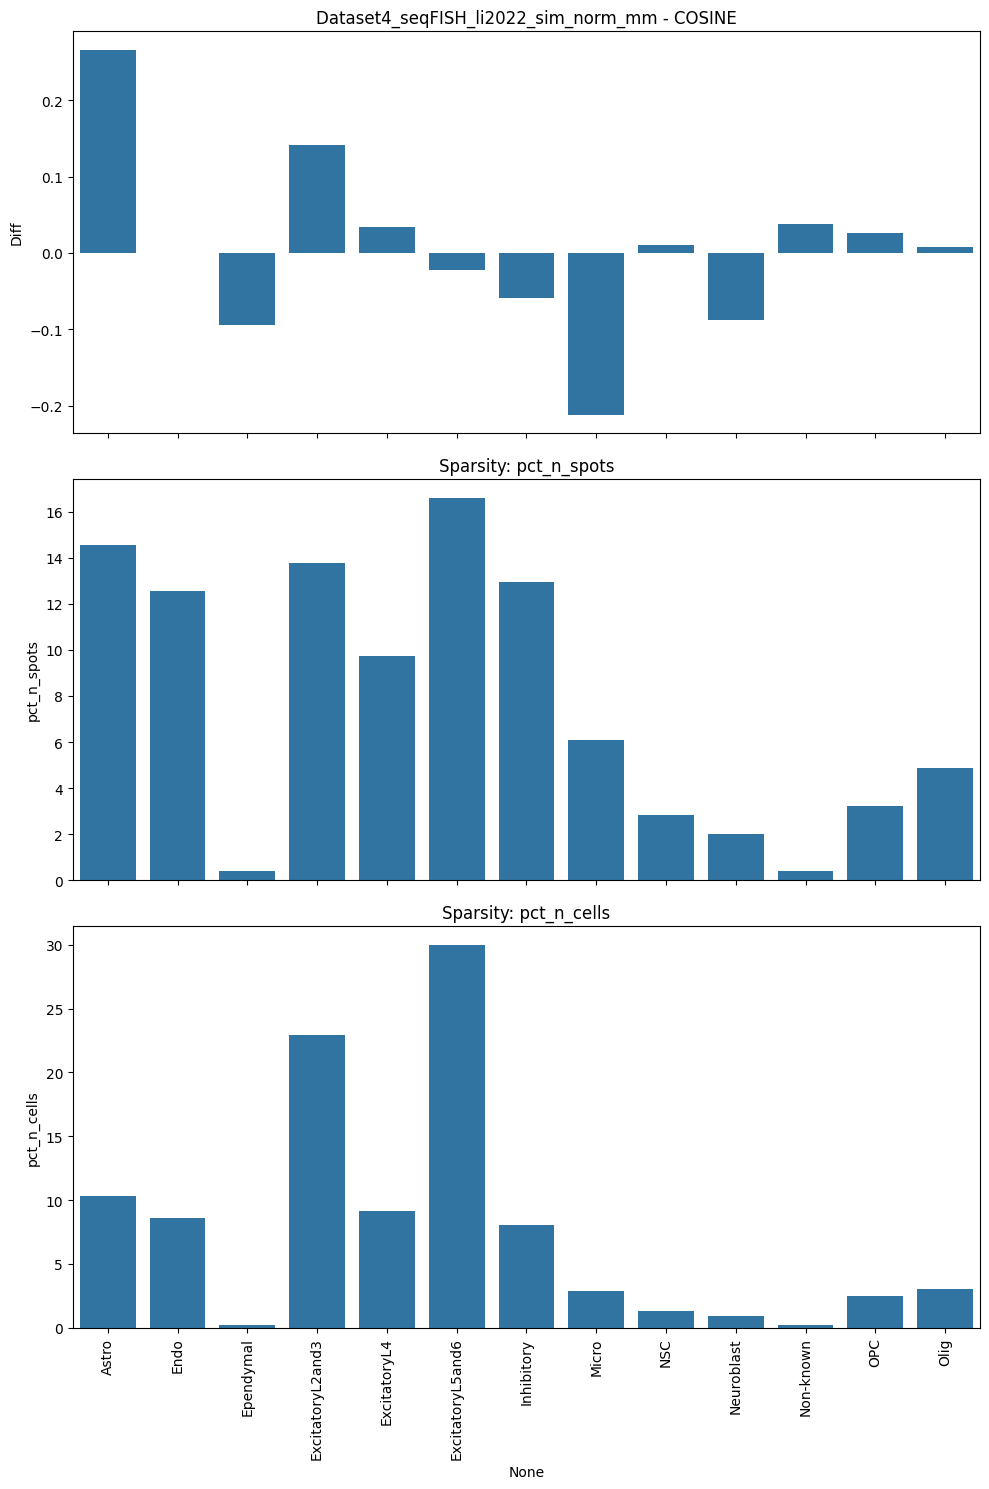

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  



# Prepare main metric pivot
df_pivot = dfs.pivot(index="celltype", columns="experiment", values=metric)
df_pivot['Diff'] = df_pivot[f"{svg_2.replace("_use_unadjusted_pvals_","").replace("alse","").replace("rue","")}_ot"] - df_pivot[f"{svg_1.replace("_use_unadjusted_pvals_","").replace("alse","").replace("rue","")}_ot"]

# Keep only matching indices in both dataframes
common_index = df_pivot.index.intersection(df_sparsity.index)
df_pivot = df_pivot.loc[common_index]
df_sparsity = df_sparsity.loc[common_index]

# Define the number of subplots (1 for Diff + the number of columns in df_sparsity)
num_subplots = 1 + df_sparsity.shape[1]

# Create subplots with shared x-axis
fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 5 * num_subplots), sharex=True)

# Plot the 'Diff' barplot in the first subplot
sns.barplot(x=df_pivot.index, y=df_pivot['Diff'], ax=axes[0])
axes[0].set_title(f"{dataset} - {metric}")
axes[0].set_ylabel("Diff")
axes[0].tick_params(axis='x', rotation=90)

# Plot the sparsity data in the remaining subplots
for i, col in enumerate(df_sparsity.columns):
    sns.barplot(x=df_sparsity.index, y=df_sparsity[col], ax=axes[i + 1])
    axes[i + 1].set_title(f"Sparsity: {col}")
    axes[i + 1].set_ylabel(col)
    axes[i + 1].tick_params(axis='x', rotation=90)


# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import matplotlib.patches as patches



correlation_type = "cosine"

# Initialize a dictionary to store aggregated data for all datasets
# aggregated_data = {metric: [] for metric in ['PCC', 'COSINE', 'RMSE', 'JS', 'RBO', 'nDCG', 'AS_S', 'AS_G']}
aggregated_data = {metric: [] for metric in ['COSINE', 'RBO','pct_n_spots','pct_n_cells']}

datasets_metrics = {}

# Initialize variables for determining the global x-axis limits
all_x_vals = []

# Loop through each sample in running_datasets
for sample_name in running_datasets:
    # Load data
    df_corr = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", "correlations", f"{sample_name}_{correlation_type}.csv"), index_col=0)
    np.fill_diagonal(df_corr.values, 0)
    df_metrics = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", f"metrics_{sample_name}.csv"))
    df_sparsity = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", "sparsity_{sample_name}.csv"),index_col=0)

    datasets_metrics[sample_name] = df_celltypes

    # Collect all x-values for consistent scaling across datasets
    all_x_vals.extend(df_celltypes.index.tolist())

    # Process the metrics
    for metric in ['COSINE','RBO']:
    # for metric in ['PCC', 'COSINE', 'RMSE', 'JS', 'RBO', 'nDCG', 'AS_S', 'AS_G']:
        df_pivot = df_metrics.pivot(index="celltype", columns="experiment", values=metric)
        df_pivot['Diff'] = df_pivot["ot"] - df_pivot["cnmf"]
        df_celltypes = df_celltypes.reindex(df_pivot.index)
        df_celltypes[f'{metric}'] = df_pivot['Diff']

        aggregated_data[metric].append({
            "dataset": sample_name,
            "data": df_celltypes[[f'{metric}']]
        })

    for metric in df_sparsity.columns:
        aggregated_data[metric].append({
            "dataset": sample_name,
            "data": df_sparsity[[f'{metric}']]
        })


# Set up the figure layout with additional space for the boxplot
num_metrics = len(aggregated_data)
fig, axes = plt.subplots(
    nrows=num_metrics + 1, 
    ncols=len(running_datasets), 
    figsize=(10* len(running_datasets), 8 * (num_metrics + 1)),
    sharex=False,
    sharey='row'
)

sorted_columns_list = []
# Create the first plot (Boxplot for min, mean, max of cosine correlations)
for col_idx, sample_name in enumerate(running_datasets):
    df_corr = pd.read_csv(os.path.join(results_dir, sample_name, "analysis", "correlations", f"{sample_name}_{correlation_type}.csv"), index_col=0)
    np.fill_diagonal(df_corr.values, 0)
    sorted_columns = df_corr.max().sort_values(ascending=False).index
    df_corr = df_corr[sorted_columns]
    sorted_columns_list.append(sorted_columns)


    sns.boxplot(data=df_corr, ax=axes[0, col_idx], palette="Set2", boxprops=dict(facecolor='none', edgecolor='black'))
    # Annotate the maximum value
    for i, column in enumerate(df_corr.columns):
            mean_value = df_corr[column].mean()
            max_value = df_corr[column].max()
            axes[0, col_idx].text(
                i, max_value, f"{max_value:.3f}\nm={mean_value:.3f}",  # format the value to 3 decimal points
                ha="center", va="bottom", fontsize=10, color= 'red' if max_value >=0.3 else "black"
            )
            # if(max_value >=0.3):
            #     # Add the circle above the text
            #     circle = patches.Circle(
            #         (i, max_value + 0.04),  # Position slightly above the text
            #         radius=0.01,            # Radius of the circle
            #         color='red',            # Same color as the text
            #         fill=True
            #     )
            #     axes[0, col_idx].add_artist(circle)


    axes[0, col_idx].set_title(f"{sample_name} - Correlations")
    axes[0, col_idx].set_ylabel("Cosine Correlations (Inner)")
    axes[0, col_idx].set_xlabel("Celltypes")
    axes[0, col_idx].tick_params(axis='x', rotation=90)

# Plot the remaining metrics
for row_idx, (metric, data_list) in enumerate(aggregated_data.items()):
    for col_idx, dataset_data in enumerate(data_list):
        dataset_name = dataset_data["dataset"]
        df_data = dataset_data["data"]
        df_data = df_data.loc[sorted_columns_list[col_idx]]
        ax = axes[row_idx + 1, col_idx]
        # colors = ['red' if value > 0 else 'blue' for value in df_data[f'{metric}']]
        colors = [
        'blue' if value < -0.1 else
        'lightblue' if value < 0 else
        'lightcoral' if value <= 0.1 else
        'red'
        for value in df_data[f'{metric}']
         ]
        
        sns.barplot(
            x=df_data.index, 
            y=df_data[f'{metric}'], 
            ax=ax, 
            palette=colors
        )
        ax.set_title(f"{dataset_name} - {metric}")
        ax.set_ylabel(metric if col_idx == 0 else "")
        ax.set_xlabel("Celltypes" if row_idx == num_metrics - 1 else "")
        ax.tick_params(axis='x', rotation=90)


# Adjust layout
plt.suptitle("Comparative Metrics Across Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save or show the plot
# plt.savefig("aggregated_metrics_plot_with_boxplot.pdf")  # Adjust path as needed
plt.savefig(os.path.join(r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data", "CelltypeStats", f"stats_per_celltype_sorted_mean_density_threshold.pdf"))
plt.show()


## Single Cell

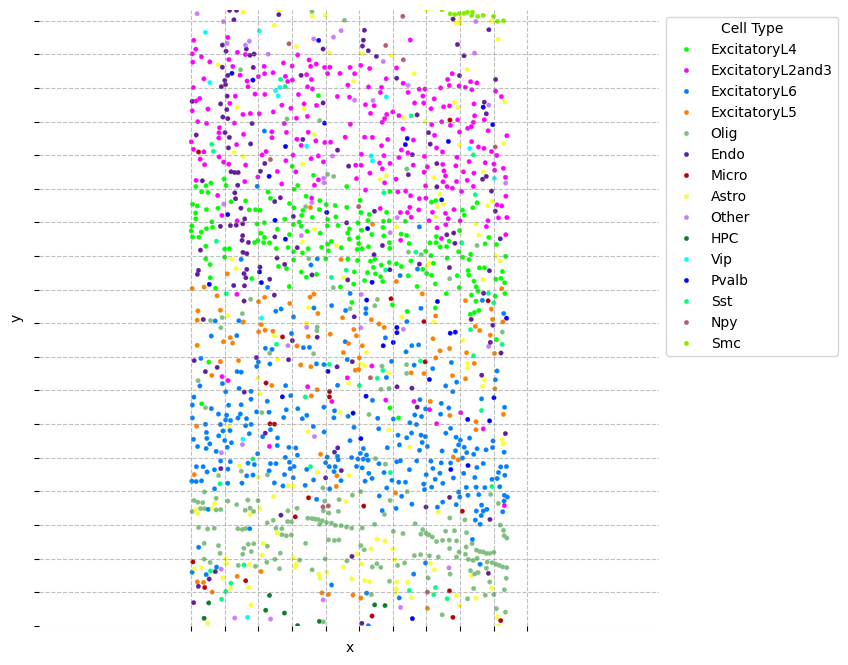

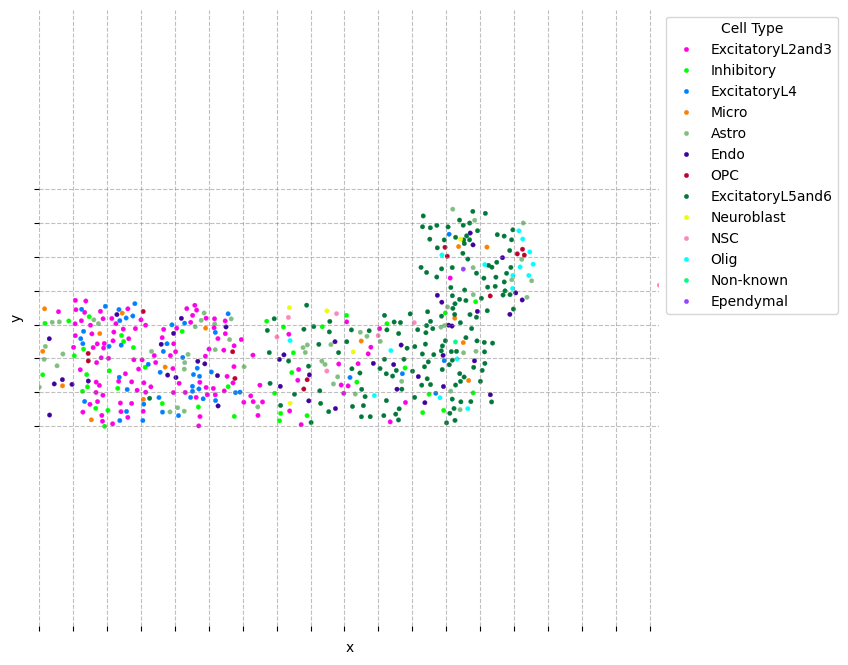

In [20]:
import os
import scanpy as sc
import sys
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import distinctipy
import pandas as pd
import seaborn as sns
import numpy as np
sys.path.append('..')
from TUT import tut
import matplotlib.patches as patches

base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
data_dir = os.path.join(base_dir, "data")
results_dir = tut.process.utils.check_dir(os.path.join(base_dir, "ismb_results_wassgard"))
manuscript_dir = r'Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard'


dataset_list = {
    "Dataset10_STARmap_li2022_sim_norm_mm" : {
        "window" : 750
    },
    "Dataset4_seqFISH_li2022_sim_norm_mm" : {
        "window" : 500
    },
    # "stereoseq_mouse_brain_li2023_sim_norm_mm": {
    # },
}


running_datasets = dataset_list.keys()

def get_single_cell_data_li2022(directory):
    df_counts = pd.read_csv(os.path.join(directory, "Rawdata/Spatial_count.txt"), sep='\t' ,index_col=0)
    df_corrd = pd.read_csv(os.path.join(directory, "Rawdata/Locations.txt"), sep='\t')
    df_annot = pd.read_csv(os.path.join(directory, "Rawdata/Spatial_annotate.txt"), sep='\t', index_col=0)
    adata = sc.AnnData(X=df_counts.values, obs=df_annot, var={'genes': df_counts.columns})
    adata.obs[["X", "Y"]] = df_corrd.values

    adata.uns["dataset_name"] = os.path.basename(directory)
    return adata


def plot_sim_spatial_single(adata_sc, results_dir, dataset, window=750, is_show=False):
    # Shift both x and y so that the minimum values become 0
    data = {
        'x': adata_sc.obs["X"] - adata_sc.obs["X"].min(),
        'y': adata_sc.obs["Y"] - adata_sc.obs["Y"].min(),
        'Cell Type': adata_sc.obs["celltype"]
    }
    df = pd.DataFrame(data)
    sample_name = adata_sc.uns["dataset_name"]

    # Generate a palette based on unique cell types
    unique_types = df['Cell Type'].unique()
    palette = distinctipy.get_colors(len(unique_types))
    palette_dict = dict(zip(unique_types, palette))

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    sns.scatterplot(data=df, x='x', y='y', hue='Cell Type', palette=palette_dict, s=10, edgecolor=None, ax=ax)

    # Fix the aspect ratio so grid squares are perfect squares
    ax.set_aspect('equal', adjustable='datalim')

    # Determine x and y limits (starting from 0 now)
    x_min, x_max = 0, df["x"].max()
    y_min, y_max = 0, df["y"].max()
    xticks = np.arange(0, x_max + window, window)
    yticks = np.arange(0, y_max + window, window)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # Optionally remove tick labels and frame for a cleaner look
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Set axis limits explicitly so the plot starts at (0,0)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Draw grid lines based on the ticks
    ax.grid(True, which="both", linestyle="--", color='grey', alpha=0.5)

    plt.legend(title='Cell Type', bbox_to_anchor=(1, 1))
    # Save and optionally show the plot
    save_path = os.path.join(results_dir, dataset, "analysis", f"{sample_name}_scdata_plot.pdf")
    plt.savefig(save_path, bbox_inches='tight')
    if is_show:
        plt.show()
    plt.close()

for dataset in running_datasets:
    dataset_path = os.path.join(data_dir, dataset) 
    adata_sc = get_single_cell_data_li2022(dataset_path)
    plot_sim_spatial_single(adata_sc, results_dir, dataset, window=dataset_list[dataset]["window"], is_show= True)

## Silver Standard Benchmark

### 1. Run Topic Modeling All

In [ ]:
import os
import scanpy as sc
import sys
sys.path.append('..')
from TUT import tut
from Wassgard.wassgard import io

base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark\\silverstandard"
data_dir = os.path.join(base_dir, "data")
manuscript_dir = r'Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard'

# experiments_list = ["cot", "cnmf", "ot", "nmf", "lda"]
experiments_list = ["cnmf", "nmf", "stdecon"]


samples_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\morrissy-chan\control\mouse10x_cell2loc"
adata_spatial = io.read_spatial_data(samples_dir, is_aggr=True, is_xenograft=False, is_spatial=True)
sample_name = "normal_mouse_cell2loc"
adata_spatial.uns["dataset_name"] = sample_name


# """Run experiments and annotations for a given adata."""
for exp_name in ["stdecon"]:
    print(sample_name, exp_name)
    k=65
    results_dir = tut.process.utils.check_dir(os.path.join(base_dir, f"{sample_name}_{k}"))
    tut.run_experiment(adata_spatial, k, sample_name, exp_name,
                        results_dir = os.path.join(results_dir, sample_name), filter_genes=True)

### 2. Silver Standard Benchmark Scores

In [1]:
import os
import pandas as pd
import scanpy as sc
import sys
sys.path.append('..')
from TUT import tut
from Wassgard.wassgard import io,annotate


def load_cell2location_results(rank):
    cell2location_results = "Z:/MorrissyLab Dropbox/Visium_profiling/benchmark/cell2location_paper/notebooks/selected_results/mouse_visium_snrna"

    silver_standard_dict = {
        59: "LocationModelLinearDependentWMultiExperiment_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/W_cell_density_q05.csv",
        65: "LocationModelLinearDependentWMultiExperiment_65clusters_14968locations_12807genes_n_comb50_mean_var5_inferred_30k//W_cell_density_q05.csv",
        98: "LocationModelLinearDependentWMultiExperiment_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k/W_cell_density_q05.csv",
        121: "LocationModelLinearDependentWMultiExperiment_121clusters_1393locations_13566genes_n_comb150_mean_var5_30k/W_cell_density_q05.csv"
    }

    samples_dict = {'ST8059048': 1, 'ST8059049': 2, 'ST8059050': 3, 'ST8059051': 4, 'ST8059052': 5}

    if rank not in silver_standard_dict:
        raise ValueError(f"Invalid rank: {rank}. Available ranks: {list(silver_standard_dict.keys())}")

    file_path = os.path.join(cell2location_results, silver_standard_dict[rank])
    
    cell2location_df = pd.read_csv(file_path, index_col=0)
    cell2location_df.columns = cell2location_df.columns.str.replace('q05_spot_factors', '', regex=False)
    cell2location_df.index = cell2location_df.index.map(lambda x: x.split('_')[-1].replace('1', str(samples_dict.get(x.split('_')[0], x.split('_')[-1]))))

    return cell2location_df


# rank = 59
# cell2location_df = load_cell2location_results(rank)
# for exp in ["nmf", "cnmf", "stdecon"]:
#     sample_name = f"{exp}_normal_mouse_cell2loc"
#     results_dir_path = fr"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\silverstandard\{sample_name}_{rank}"
#     rf_usages= pd.read_csv(os.path.join(results_dir_path, f"topics_per_spot_{sample_name}_{rank}.csv"),index_col=0).fillna(0)

#     annotate.benchmark_corr_silverstandard(results_dir_path, cell2location_df, rf_usages, correlation_type = "cosine", title=f"{sample_name}_{rank}")


# rank = 65
# cell2location_df = load_cell2location_results(rank)
# for exp in ["nmf", "cnmf"]:
#     sample_name = f"{exp}_normal_mouse_cell2loc"
#     results_dir_path = fr"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\silverstandard\{sample_name}_{rank}"
#     rf_usages= pd.read_csv(os.path.join(results_dir_path, f"topics_per_spot_{sample_name}_{rank}.csv"),index_col=0).fillna(0)

#     annotate.benchmark_corr_silverstandard(results_dir_path, cell2location_df, rf_usages, correlation_type = "cosine", title=f"{sample_name}_{rank}")


rank = 59
cell2location_df = load_cell2location_results(rank)
sample_name = f"normal_mouse_cell2loc"
results_dir_path = fr"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\silverstandard\{sample_name}_{rank}"
rf_usages= pd.read_csv(os.path.join(results_dir_path, f"topics_per_spot_{sample_name}_{rank}.csv"),index_col=0).fillna(0)
annotate.benchmark_corr_silverstandard(results_dir_path, cell2location_df, rf_usages, correlation_type = "cosine", title=f"{sample_name}_{rank}")    

### 3. Plot cell2location

In [ ]:
## Cell2location plot
import os
import pandas as pd
import scanpy as sc
import json
from pathlib import Path
from matplotlib.image import imread
import sys
sys.path.append('..')
from Wassgard.wassgard import io, pl


def load_cell2location_results(rank):
    cell2location_results = "Z:/MorrissyLab Dropbox/Visium_profiling/benchmark/cell2location_paper/notebooks/selected_results/mouse_visium_snrna"

    silver_standard_dict = {
        59: "LocationModelLinearDependentWMultiExperiment_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/W_cell_density_q05.csv",
        65: "LocationModelLinearDependentWMultiExperiment_65clusters_14968locations_12807genes_n_comb50_mean_var5_inferred_30k//W_cell_density_q05.csv",
        98: "LocationModelLinearDependentWMultiExperiment_98clusters_1393locations_13562genes_n_comb150_mean_var5_30k/W_cell_density_q05.csv",
        121: "LocationModelLinearDependentWMultiExperiment_121clusters_1393locations_13566genes_n_comb150_mean_var5_30k/W_cell_density_q05.csv"
    }

    samples_dict = {'ST8059048': 1, 'ST8059049': 2, 'ST8059050': 3, 'ST8059051': 4, 'ST8059052': 5}

    if rank not in silver_standard_dict:
        raise ValueError(f"Invalid rank: {rank}. Available ranks: {list(silver_standard_dict.keys())}")

    file_path = os.path.join(cell2location_results, silver_standard_dict[rank])
    
    cell2location_df = pd.read_csv(file_path, index_col=0)
    cell2location_df.columns = cell2location_df.columns.str.replace('q05_spot_factors', '', regex=False)
    cell2location_df.index = cell2location_df.index.map(lambda x: x.split('_')[-1].replace('1', str(samples_dict.get(x.split('_')[0], x.split('_')[-1]))))

    return cell2location_df

samples_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\morrissy-chan\control\mouse10x_cell2loc"
output_dir = r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data\cell2location_mouse_fig5"

dataset_name = f"normal_mouse_cell2loc"
rank = 59
adata = io.read_spatial_data(samples_dir, is_aggr=True, is_xenograft=False, is_spatial=True)
cell2location_df = load_cell2location_results(rank)
pl.plot_spatial_all_topics_aggr_manuscript(adata, cell2location_df, output_dir, title_name=f"gt_{dataset_name}_{rank}", same_legend = False, plot_topic=True, COLS=10, ROWS=15)

for exp_name in ["", "cnmf_", "nmf_", "stdecon_"]:
    sample_name = f"{exp_name}{dataset_name}"
    results_dir_path = fr"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\cell2location_case_study\{sample_name}_{rank}"
    rf_usages= pd.read_csv(os.path.join(results_dir_path, f"topics_per_spot_{sample_name}_{rank}.csv"),index_col=0)
    pl.plot_spatial_all_topics_aggr_manuscript(adata, rf_usages, output_dir, title_name=f"{sample_name}_{rank}", same_legend = False, plot_topic=True, COLS=10, ROWS=15)


### 4. Subset of programs

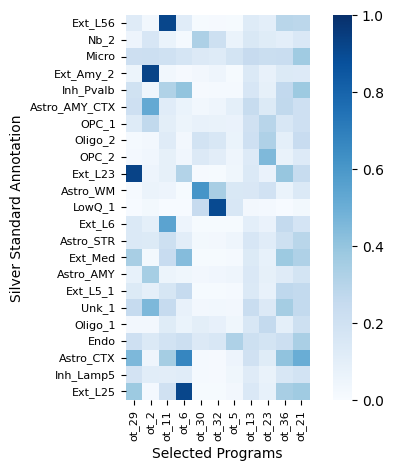

In [70]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

output_dir = r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data\cell2location_mouse_fig5"
# Set PDF font type to Type 42
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


silver_standard_corr_df = pd.read_csv(r"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\cell2location_case_study\normal_mouse_cell2loc_59\SS_Annotation\ss_correlation_normal_mouse_cell2loc_59_cosine.csv", index_col =0)

subset_programs = ["ot_29", "ot_2", "ot_11", "ot_6", ### Best match
                   "ot_30", "ot_32", "ot_5", "ot_13", "ot_23", ## Better than supervised
                   "ot_36", "ot_21"
                   ]

silver_standard_corr_df = silver_standard_corr_df.loc[:, subset_programs]
silver_standard_corr_df = silver_standard_corr_df[silver_standard_corr_df.mean(axis=1) >= 0.1]


fig, ax = plt.subplots(figsize=(6, 5))
# Plot heatmap
sns.heatmap(
    silver_standard_corr_df.astype(float),
    annot=False,
    cmap="Blues",
    ax=ax,
    square=True,
    cbar=True,
    vmin=0,
    vmax=1,
)
x_label = "Selected Programs"
y_label = "Silver Standard Annotation"
ax.set_title('', fontsize=12)
ax.set_xlabel(x_label, fontsize=10)
ax.set_ylabel(y_label, fontsize=10)

# Ticks
ax.set_xticks(np.arange(len(silver_standard_corr_df.columns)) + 0.5)
ax.set_xticklabels(silver_standard_corr_df.columns, rotation=90, fontsize=8)
ax.set_yticks(np.arange(len(silver_standard_corr_df.index)) + 0.5)
ax.set_yticklabels(silver_standard_corr_df.index, rotation=0, fontsize=8)

plt.savefig(os.path.join(output_dir, f"annotation_corr_heatmap_subset.pdf"))
plt.show()


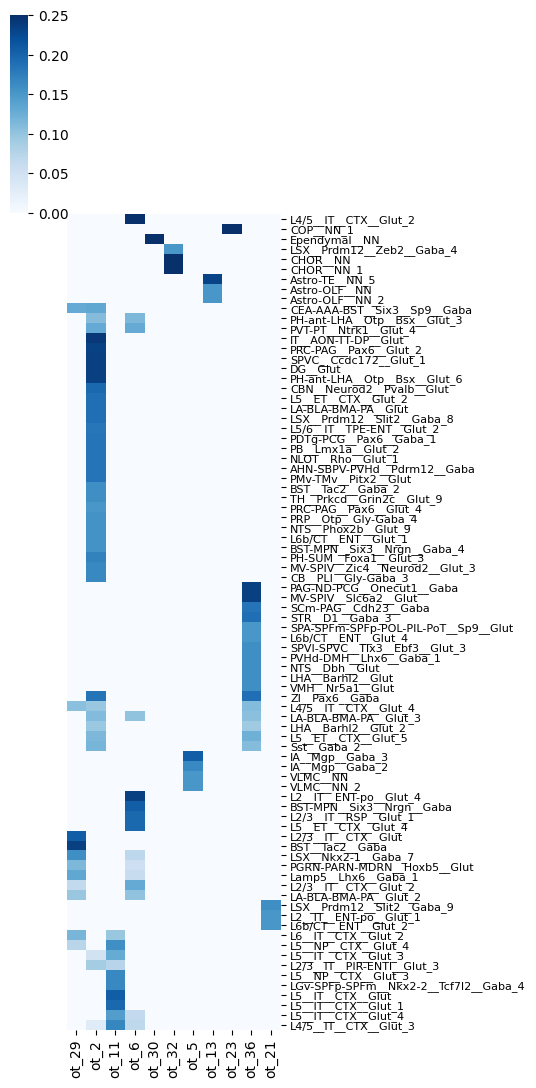

In [91]:
import pandas as pd
import seaborn as sns

import os
from glob import glob

# Step 1: Define path to directory with files
directory = r"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\cell2location_case_study\normal_mouse_cell2loc_59\genesets_results"  # ← change this to your actual directory

# Step 2: Read and merge all CSVs that start with "genesets_scores_"
all_files = glob(os.path.join(directory, "genesets_scores_*.csv"))

# Step 3: Concatenate them into a single DataFrame
df_list = [pd.read_csv(f, index_col=0) for f in all_files]
merged_df = pd.concat(df_list, axis=0)
merged_df = merged_df.loc[:, subset_programs]
merged_df = merged_df[merged_df.sum(axis=1) >= 0.15]
merged_df.index = merged_df.index.str.replace(r'^\d+__', '', regex=True)

g = sns.clustermap(
    merged_df.astype(float),
    cmap="Blues",
    figsize=(6, 11),
    xticklabels=True,
    yticklabels=True,
    vmin=0,
    vmax=0.25,
    col_cluster=False,  # Hide column dendrogram
    metric='euclidean',
    method='average',
    cbar_pos=(0.02, 0.8, 0.03, 0.18),  # adjust position and size of colorbar
)
# Hide dendrogram axes (clustering lines)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=8)

plt.savefig(os.path.join(output_dir, f"genesets_rbo_clustermap_subset.pdf"))
plt.show()

### 5. Affect of Threshold

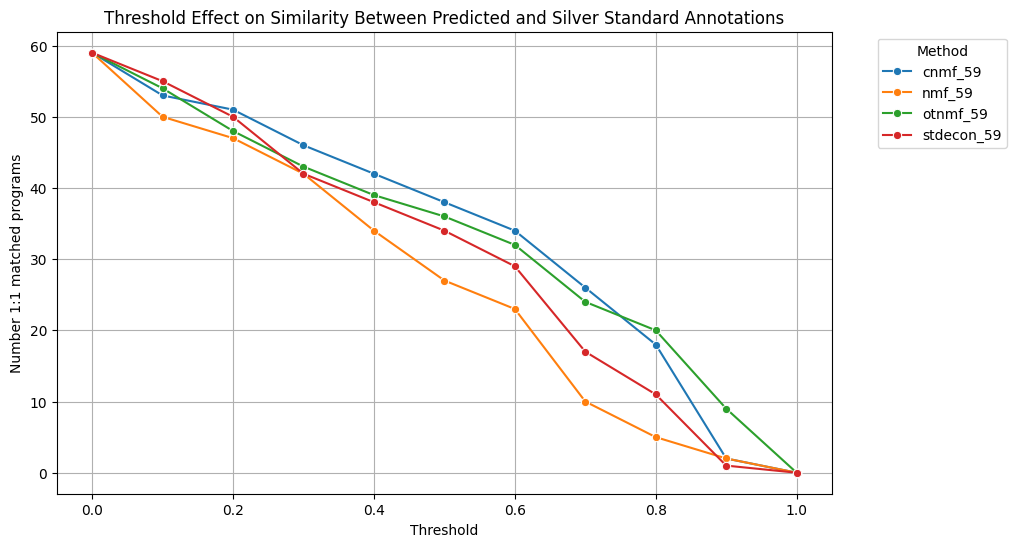

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set PDF font type to Type 42
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

results_dir_path = fr"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\silverstandard"
# Dictionary to store DataFrames
dataframes_dict = {}

# Walk through the directory
for root, _, files in os.walk(results_dir_path):
    for file in files:
        if file.endswith(".csv") and file.startswith("ss_correlation"):
            # Get the relative path from results_dir_path
            rel_path = os.path.relpath(root, results_dir_path)
            # Extract the folder name (first level)
            folder_name = rel_path.split(os.sep)[0]
            # Construct full file path
            file_path = os.path.join(root, file)
            # Load CSV into dictionary
            dataframes_dict[folder_name] = pd.read_csv(file_path, index_col=0)



# Define thresholds from 0 to 1 (inclusive) with a step of 0.1
thresholds = np.arange(0, 1.1, 0.1)

# Dictionary to store threshold analysis results
threshold_results = {}

# Iterate through each dataframe
for folder_name, df in dataframes_dict.items():
    counts = []
    
    # Loop through thresholds
    for threshold in thresholds:
        # Count rows where any column has a value greater than the threshold
        # count_above_threshold = 0
        # count_above_threshold += (df > threshold).any(axis=1).sum()
        # count_above_threshold += (df > threshold).any(axis=0).sum()
        count_above_threshold = (df.values.diagonal() > threshold).sum()
        # count_above_threshold = (df.values > threshold).any().sum()
        counts.append(count_above_threshold)
    
    # Store in dictionary
    threshold_results[folder_name] = counts

# Plotting
plt.figure(figsize=(10, 6))
# Iterate over results to plot each curve
for folder_name, counts in threshold_results.items():
    if('59' in folder_name):
        label = "otnmf_59" if folder_name.startswith("normal") else folder_name.replace("_normal_mouse_cell2loc","") 
        sns.lineplot(x=thresholds, y=counts, label=label, marker='o')
# Labels and title
plt.xlabel("Threshold")
plt.ylabel("Number 1:1 matched programs")
plt.title("Threshold Effect on Similarity Between Predicted and Silver Standard Annotations")
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
# plt.savefig(os.path.join(r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\Wassgard\Raw_Data", "SilverStandardBenchmark", f"silver_standard_curves_allcounts.pdf"))

plt.show()


### OT Hyperparams

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import os
import pandas as pd
import scanpy as sc
import sys
sys.path.append('..')
from TUT import tut
from spotnmf.wassgard import io,annotate

rank = 59
cell2location_df = load_cell2location_results(rank)


hyper_params_dir = r"Z:\MorrissyLab Dropbox\Visium_profiling\benchmark\cell2location_hyper2"


results_dict = {}
for experiment_file in os.listdir(hyper_params_dir):
    rf_usages= pd.read_csv(os.path.join(hyper_params_dir, experiment_file),index_col=0).fillna(0)



    common_index = cell2location_df.index.intersection(rf_usages.index)
    # Reindex both DataFrames to keep only common indices
    silver_standard_df = cell2location_df.loc[common_index]
    rf_usages = rf_usages.loc[common_index]


    df_corr = pd.DataFrame(index=silver_standard_df.columns, columns=rf_usages.columns)
    for cell_type in rf_usages.columns:
        for topic in silver_standard_df.columns:
            column_value = cosine_similarity(rf_usages[cell_type].values.reshape(1, -1), silver_standard_df[topic].values.reshape(1, -1))
            df_corr.loc[topic, cell_type] = column_value[0,0]

    df_annotate = annotate.get_annotation_from_corr(df_corr)
    sorted_programs = df_annotate.sort_values(by="celltype")["program"].values
    sorted_columns = sorted(df_corr.columns)
    df_corr = df_corr[sorted_columns].reindex(sorted_programs)

    count_above_threshold = (df_corr.values.diagonal() > 0.6).sum()

    results_dict[experiment_file.split('_')[4]] = count_above_threshold


In [6]:
# Sorting keys by values in descending order
sorted_keys = sorted(results_dict, key=lambda k: results_dict[k], reverse=True)

# Printing keys with their values
for key in sorted_keys:
    print(f"{key}: {results_dict[key]}")

lr0.001eps0.05h0.05w0.01: 32
lr0.005eps0.05h0.05w0.01: 31
lr0.01eps0.05h0.05w0.01: 31
lr0.001eps0.1h0.005w0.005: 30
lr0.001eps0.05h0.001w0.005: 29
lr0.001eps0.05h0.005w0.01: 29
lr0.001eps0.05h0.01w0.01: 29
lr0.001eps0.05h0.1w0.005: 29
lr0.001eps0.05h0.1w0.01: 29
lr0.001eps0.1h0.001w0.005: 29
lr0.005eps0.05h0.05w0.001: 29
lr0.005eps0.05h0.1w0.001: 29
lr0.005eps0.05h0.1w0.01: 29
lr0.01eps0.05h0.05w0.001: 29
lr0.01eps0.05h0.1w0.01: 29
lr0.001eps0.05h0.005w0.001: 28
lr0.001eps0.05h0.005w0.005: 28
lr0.001eps0.05h0.01w0.005: 28
lr0.001eps0.05h0.05w0.001: 28
lr0.005eps0.05h0.005w0.001: 28
lr0.005eps0.05h0.005w0.01: 28
lr0.005eps0.05h0.01w0.001: 28
lr0.005eps0.05h0.01w0.01: 28
lr0.005eps0.05h0.05w0.005: 28
lr0.005eps0.05h0.1w0.005: 28
lr0.01eps0.05h0.01w0.005: 28
lr0.01eps0.05h0.05w0.005: 28
lr0.01eps0.05h0.1w0.005: 28
topics: 28
lr0.001eps0.05h0.001w0.001: 27
lr0.001eps0.05h0.01w0.05: 27
lr0.001eps0.05h0.05w0.005: 27
lr0.001eps0.1h0.001w0.001: 27
lr0.001eps0.1h0.001w0.01: 27
lr0.001eps0.1h0.0